In [ ]:
import pandas as pd
import numpy as np
import time
import os

def process_log_file(file_path, distance_region_id, distance_region_bounds):
    columns = ['rxTime', 'packetID', 'distance', 'txID', 'rxID', 'decoded', 'lossType']
    dtypes = {
        'rxTime': float,
        'packetID': int,
        'distance': float,
        'txID': int,
        'rxID': int,
        'decoded': int,
        'lossType': int
    }
    chunksize = 10 ** 7
    
    try:
        # Read and concatenate chunks using a context manager
        chunk_list = []
        with pd.read_csv(file_path, chunksize=chunksize, names=columns, dtype=str, usecols=range(len(columns))) as reader:
            for chunk in reader:
                #print("start chunk")
                # Drop rows that don't contain numbers
                #chunk = chunk.drop(chunk[chunk['distance'] == 'distance'].index)
                
                # Convert to correct data types
                chunk = chunk.astype(dtypes)
                
                # Apply the region ID function
                chunk['region_distance_id'] = chunk['distance'].apply(lambda x: get_pair_region_id(x, distance_region_id, distance_region_bounds))
                
                chunk_list.append(chunk)

                #print("next chunk")
        
        # Concatenate all chunks into a single DataFrame
        df = pd.concat(chunk_list, ignore_index=True)
        
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print("Error: No data found in the file.")
        return None
    except pd.errors.ParserError:
        print("Error: Parsing error encountered while reading the file.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

def get_pair_region_id(distance, list_id_region, list_bounds_region):
    for i in list_id_region:
        if (distance <= list_bounds_region[i+1]) & (distance > list_bounds_region[i]):
            
            return i

#def process_vehicle_pairs(df):
    
    #df_pairs = df.groupby(['txID','rxID'])['distance'].apply(list).reset_index()
    #df_pairs['distance'] = df_pairs['distance'].apply(set)
    #df_pairs['distance'] = df_pairs['distance'].apply(list)
    #df_pairs['region_distance_id'] = df_pairs['distance'].apply(lambda x: get_pair_region_id(x[0], distance_region_id, distance_region_bounds))
    #df['region_distance_id'] = df['distance'].apply(lambda x: get_pair_region_id(x, distance_region_id, distance_region_bounds))
    
    #return df_pairs

def form_df_regions(list_id_region, df):

    df_regions = pd.DataFrame()

    for i in list_id_region:
        #pairs_number = int(len(df_pairs[df_pairs['region_distance_id'] == i])/2)
        decoded_count = len(df[(df['decoded'] == 1) & (df['region_distance_id'] == i)])
        collision_count = len(df[(df['lossType'] == 3) & (df['region_distance_id'] == i)])
        propagation_count = len(df[((df['lossType'] == 1) | (df['lossType'] == 0)) & (df['region_distance_id'] == i)])

        #df_regions.loc[i, 'pairs_number'] = pairs_number
        df_regions.loc[i, 'decoded'] = decoded_count
        df_regions.loc[i, 'collision'] = collision_count
        df_regions.loc[i, 'propagation'] = propagation_count

        df_regions = df_regions.astype(int) 

    return df_regions

def list_length_greater_than_50(lst):
    return len(lst) > 1

def get_pir(input_df, var_parameter):
    # Filter where 'decoded' is 1
    input_df = input_df[input_df['decoded'] == 1]
    
    # Initialize an empty DataFrame with the required columns
    test_df = pd.DataFrame(columns=['txID','rxID','rxTime','distance', 'pir', 'pir_sqr', 'mean_pir', 'mean_pir_sqr','aoi','pkeep'])
    
    # Group by 'txID' and 'rxID', aggregating 'rxTime' into lists and taking the first value of 'distance'
    grouped = input_df.groupby(['txID', 'rxID']).agg({
        'rxTime': list,  # Keep rxTime as a list
        'distance': 'first'  # Take the first distance value (since they're all the same)
    })
    
    # Reset index to get 'txID' and 'rxID' as columns
    grouped = grouped.reset_index()
    
    # Assign 'txID', 'rxID', 'rxTime', and 'distance' to the DataFrame
    test_df['txID'] = grouped['txID']
    test_df['rxID'] = grouped['rxID']
    test_df['rxTime'] = grouped['rxTime']
    test_df['distance'] = grouped['distance']

    # Calculate pir and pir_sqr
    test_df['pir'] = test_df['rxTime'].apply(np.diff)
    test_df['pir_sqr'] = test_df['pir'].apply(lambda x: x ** 2)
    
    # Calculate mean pir and mean pir_sqr for each row
    test_df['mean_pir'] = test_df['pir'].apply(np.mean)
    test_df['mean_pir_sqr'] = test_df['pir_sqr'].apply(np.mean)
    
    # Calculate AoI for each row
    test_df['aoi'] = test_df.apply(lambda row: row['mean_pir_sqr'] / (2 * np.mean(row['pir'])), axis=1)
    
    # Add var_parameter to pkeep column
    test_df['pkeep'] = var_parameter
    
    return test_df

def aoi_database_analysis (df_pir, var_parameter):
    # Calculate the interquartile range (IQR) for pir and aoi
    Q1_pir = df_pir['mean_pir'].quantile(0.25)
    Q3_pir = df_pir['mean_pir'].quantile(0.75)
    IQR_pir = Q3_pir - Q1_pir

    Q1_aoi = df_pir['aoi'].quantile(0.25)
    Q3_aoi = df_pir['aoi'].quantile(0.75)
    IQR_aoi = Q3_aoi - Q1_aoi

    # Define bounds for outliers
    lower_bound_pir = Q1_pir - 1.5 * IQR_pir
    upper_bound_pir = Q3_pir + 1.5 * IQR_pir

    lower_bound_aoi = Q1_aoi - 1.5 * IQR_aoi
    upper_bound_aoi = Q3_aoi + 1.5 * IQR_aoi

    # Find how many rows are outliers for pir and aoi
    outliers_pir = df_pir['mean_pir'][(df_pir['mean_pir'] < lower_bound_pir) | (df_pir['mean_pir'] > upper_bound_pir)].count()
    outliers_aoi = df_pir['aoi'][(df_pir['aoi'] < lower_bound_aoi) | (df_pir['aoi'] > upper_bound_aoi)].count()

    total_rows = df_pir.shape[0]

    percentage_outliers_pir = (outliers_pir / total_rows) * 100
    percentage_outliers_aoi = (outliers_aoi / total_rows) * 100

    # Calculate the mean for PIR and AoI
    mean_pir = df_pir['mean_pir'].mean()
    mean_aoi = df_pir['aoi'].mean()

    # Count values lower than the mean
    lower_than_mean_pir = df_pir['mean_pir'][df_pir['mean_pir'] < mean_pir].count()
    lower_than_mean_aoi = df_pir['aoi'][df_pir['aoi'] < mean_aoi].count()

    # Calculate the percentage of values lower than the mean
    percentage_lower_than_mean_pir = (lower_than_mean_pir / total_rows) * 100
    percentage_lower_than_mean_aoi = (lower_than_mean_aoi / total_rows) * 100

    # Calculate percentage of values higher than mean but within quantiles
    higher_than_mean_in_quantile_pir = df_pir['mean_pir'][(df_pir['mean_pir'] > mean_pir) & 
                                                        (df_pir['mean_pir'] < upper_bound_pir)].count()
    percentage_higher_than_mean_in_quantile_pir = (higher_than_mean_in_quantile_pir / total_rows) * 100

    higher_than_mean_in_quantile_aoi = df_pir['aoi'][(df_pir['aoi'] > mean_aoi) & 
                                                    (df_pir['aoi'] < upper_bound_aoi)].count()
    percentage_higher_than_mean_in_quantile_aoi = (higher_than_mean_in_quantile_aoi / total_rows) * 100

    # Write the results to a single row CSV file
    results_row = {
        'Mean_AoI': mean_aoi,
        'Mean_PIR': mean_pir,
        'Percentage_outliers_PIR': percentage_outliers_pir,
        'Percentage_outliers_AoI': percentage_outliers_aoi,
        'Percentage_lower_than_mean_PIR': percentage_lower_than_mean_pir,
        'Percentage_lower_than_mean_AoI': percentage_lower_than_mean_aoi,
        'Percentage_higher_than_mean_in_quantile_PIR': percentage_higher_than_mean_in_quantile_pir,
        'Percentage_higher_than_mean_in_quantile_AoI': percentage_higher_than_mean_in_quantile_aoi,
        'Pkeep' : var_parameter
    }

    # Convert to DataFrame and write to CSV
    df_results_row = pd.DataFrame([results_row])
    # Append the new row to the existing CSV file without headers
    df_results_row.to_csv('525_aoi_database_analysis_rc1.csv', mode='a', index=False, header=False)

def get_metrics(list_region_id, df_regions, df_pir, df, parameter):

    df_metrics = pd.DataFrame()
    
    pairs_regions = df.groupby(['txID', 'rxID'])['region_distance_id'].first().reset_index()
    pairs_regions.set_index(['txID', 'rxID'], inplace=True)
    merged_df = df_pir.join(pairs_regions, on=['txID', 'rxID'])

    for i in list_region_id:

        df_metrics.loc[i, 'region_id'] = i
        df_metrics.loc[i, 'region_max_distance'] = distance_region_bounds[i]
        df_metrics.loc[i, 'weight'] = len(pairs_regions[pairs_regions['region_distance_id']==i]) / len(pairs_regions)
        df_metrics.loc[i, 'var_parameter'] = parameter
        df_metrics.loc[i, 'PDR'] = df_regions['decoded'][i] / (df_regions['decoded'][i] + df_regions['collision'][i] + df_regions['propagation'][i])
        df_metrics.loc[i, 'CLR'] = df_regions['collision'][i] / (df_regions['decoded'][i] + df_regions['collision'][i] + df_regions['propagation'][i])
        df_metrics.loc[i, 'PLR'] = df_regions['propagation'][i] / (df_regions['decoded'][i] + df_regions['collision'][i] + df_regions['propagation'][i])
        

        df_metrics.loc[i, 'mean_paoi'] = merged_df[merged_df['region_distance_id'] == i]['mean_pir'].mean()

        #df_metrics.loc[i, 'mean_paoi'] = merged_df[merged_df['region_distance_id'] == i]['max_pir'].mean()
    
        df_metrics.loc[i, 'mean_aoi'] = (merged_df[merged_df['region_distance_id'] == i]['mean_pir_sqr'] / (2 * merged_df[merged_df['region_distance_id'] == i]['mean_pir'])).mean()  
        
    df_metrics['region_id'] = df_metrics['region_id'].astype(int)

    #df_metrics = df_metrics.dropna()
    
    #mean_pir_by_pair = df_pir.groupby(['txID','rxID'])[['mean_pir', 'mean_pir_sqr']].mean()
    #df_pairs = df_pairs.merge(mean_pir_by_pair, left_on=['txID','rxID'], right_index=True, how='left')
    #df_pairs['aoi'] = df_pairs['mean_pir_sqr'] / (2 * df_pairs['mean_pir'])
    
    #df_metrics['mean_paoi'] = df_pairs.groupby('region_distance_id')['mean_pir'].mean()
    #df_metrics['mean_aoi'] = df_pairs.groupby('region_distance_id')['aoi'].mean()
        
    return df_metrics

def get_avg_metrics(df_metrics):   
    df_avg_metrics= pd.DataFrame(columns=['parameter', 'mean_PDR', 'mean_CLR', 'mean_PLR', 'mean_PAoI', 'mean_AoI'])

    new_row = {
        'parameter': df_metrics['var_parameter'][0],
        'mean_PDR': (df_metrics['PDR'] * df_metrics['weight']).sum() / df_metrics['weight'].sum(), #количество регионов
        'mean_CLR': (df_metrics['CLR'] * df_metrics['weight']).sum() / df_metrics['weight'].sum(),
        'mean_PLR': (df_metrics['PLR'] * df_metrics['weight']).sum() / df_metrics['weight'].sum(),
        'mean_PAoI': (df_metrics['mean_paoi'] * df_metrics['weight']).sum() / df_metrics['weight'].sum(),
        'mean_AoI': (df_metrics['mean_aoi'] * df_metrics['weight']).sum() / df_metrics['weight'].sum()
    }
    new_row_df = pd.DataFrame([new_row])
    df_avg_metrics = pd.concat([df_avg_metrics, new_row_df], ignore_index=True)
    
    return df_avg_metrics

def get_succ_ratio(df, var_parameter, list_region_id):   

    results = []
    
    df_decoded = df[df['decoded'] == 1]

    # Precompute grouped data for 'decoded' and overall nodes
    grouped_all_nodes = df.groupby(['txID', 'region_distance_id', 'packetID']).size().reset_index(name='all_nodes')
    grouped_decoded_nodes = df_decoded.groupby(['txID', 'region_distance_id', 'packetID']).size().reset_index(name='suc_rx_nodes')

            # Iterate over specified ranges for j and i
    for j in range(1,17):
        for i in range(0, 700):
                # Filter precomputed grouped data
                all_nodes_filtered_df = grouped_all_nodes[(grouped_all_nodes['txID'] == i) & (grouped_all_nodes['region_distance_id'] <= j)]
                filtered_df = grouped_decoded_nodes[(grouped_decoded_nodes['txID'] == i) & (grouped_decoded_nodes['region_distance_id'] <= j)]
                    
                if not filtered_df.empty:
                    # Merge the successful counts with the total counts
                    nodes_for_packet_counts = filtered_df.merge(all_nodes_filtered_df, on='packetID')
                        
                    if not nodes_for_packet_counts.empty:
                        # Calculate median and average of 'suc_rx_nodes'
                        median_val = nodes_for_packet_counts['suc_rx_nodes'].median()
                        avg_val = nodes_for_packet_counts['suc_rx_nodes'].mean()
                            
                        # Calculate the median and average ratios
                        median_ratio = median_val / nodes_for_packet_counts['all_nodes'].median()
                        avg_ratio = avg_val / nodes_for_packet_counts['all_nodes'].mean()
                            
                        # Append the result as a dictionary to the results list
                        results.append({
                            'nodeID': i,
                            'median': median_val,
                            'avg': avg_val,
                            'around_nodes': nodes_for_packet_counts['all_nodes'].mean(),
                            'median_ratio': median_ratio,
                            'avg_ratio': avg_ratio,
                            'dist_reuse': j * 50,
                            'pkeep': var_parameter
                        })

    # Convert the results list to a DataFrame
    nodes_disrt = pd.DataFrame(results)

    return (nodes_disrt)

2024-11-24 15:26:24,106	INFO worker.py:1819 -- Started a local Ray instance.


(process_parameter pid=77258) Processing file: n700/baoicchi_mob_veh_700_pKeep_0.000000_ReEval1_RC1/ReceivedLog.txt
Done! Script running time: 0.40070509910583496 seconds
{'parameter': '0.000000', 'status': 'Failed to load data'}
{'parameter': '0.100000', 'status': 'Failed to load data'}
{'parameter': '0.200000', 'status': 'Failed to load data'}
{'parameter': '0.300000', 'status': 'Failed to load data'}
(process_parameter pid=77257) Processing file: n700/baoicchi_mob_veh_700_pKeep_0.100000_ReEval1_RC1/ReceivedLog.txt [repeated 3x across cluster]


In [9]:
import ray
import modin.pandas as pd  # Replace Pandas with Modin
import numpy as np
import os
import time
from tqdm import tqdm  # For the progress bar

ray.init(ignore_reinit_error=True)

# Function to process a log file
@ray.remote
def process_log_file(file_path, distance_region_bounds):
    column_names = ["rxTime", "packetID", "distance", "txID", "rxID", "decoded", "lossType"]

    try:
        start_time = time.time()

        # Read the first 7 columns of the file
        df = pd.read_csv(file_path, header=None, names=column_names, usecols=range(7))
        
        # Assign region IDs based on distance using np.searchsorted
        df['region_distance_id'] = np.searchsorted(distance_region_bounds, df['distance'], side='right') - 1
        
        print(f"Processed log file in {time.time() - start_time:.2f} seconds")
        return df

    except Exception as e:
        print(f"Error in process_log_file: {e}")
        return None


# Function to form aggregated region metrics
@ray.remote
def form_df_regions(distance_region_id, df):
    grouped = df.groupby('region_distance_id')
    stats = grouped.agg(
        decoded=('decoded', 'sum'),
        collision=('lossType', lambda x: (x == 3).sum()),
        propagation=('lossType', lambda x: (x.isin([0, 1])).sum())
    )
    stats = stats.reindex(distance_region_id, fill_value=0).astype(int)
    return stats


# Function to compute PIR and AoI metrics
@ray.remote
def get_pir(input_df, var_parameter):
    input_df = input_df[input_df['decoded'] == 1]
    grouped = input_df.groupby(['txID', 'rxID']).agg(
        rxTime_list=('rxTime', list),
        distance=('distance', 'first')
    )
    
    grouped['pir'] = grouped['rxTime_list'].apply(np.diff)
    grouped['pir_sqr'] = grouped['pir'].apply(lambda x: x ** 2)
    grouped['mean_pir'] = grouped['pir'].apply(np.mean)
    grouped['mean_pir_sqr'] = grouped['pir_sqr'].apply(np.mean)
    grouped['aoi'] = grouped['mean_pir_sqr'] / (2 * grouped['mean_pir'])
    grouped['pkeep'] = var_parameter
    return grouped.reset_index()


# Function to calculate metrics
@ray.remote
def get_metrics(list_region_id, df_regions, df_pir, df, parameter, distance_region_bounds):
    try:
        # Precompute required data
        pairs_regions = df.groupby(['txID', 'rxID'])['region_distance_id'].first().reset_index()
        merged_df = df_pir.merge(pairs_regions, on=['txID', 'rxID'], how='left')

        total_pairs = len(pairs_regions)

        # Compute AoI and PAoI for each pair
        logs = []
        for _, pair in pairs_regions.iterrows():
            region_distance_id = pair['region_distance_id']
            tx_id, rx_id = pair['txID'], pair['rxID']
            pair_data = merged_df[(merged_df['txID'] == tx_id) & (merged_df['rxID'] == rx_id)]
            
            if not pair_data.empty:
                mean_paoi = pair_data['mean_pir'].mean()
                mean_aoi = (pair_data['mean_pir_sqr'] / (2 * pair_data['mean_pir'])).mean()
            else:
                mean_paoi, mean_aoi = None, None
            
            logs.append({
                'txID': tx_id,
                'rxID': rx_id,
                'mean_paoi': mean_paoi,
                'mean_aoi': mean_aoi,
                'pkeep': parameter,
                'region_distance_id': region_distance_id
            })

        # Save logs to a file
        logs_df = pd.DataFrame(logs)
        logs_df.to_csv(f'pp/{density}_aoi_pairs_database_1.csv', mode='a', header=False, index=False)
        
        # Group metrics computation for all regions
        metrics = (
            merged_df.groupby('region_distance_id')
            .agg(
                mean_paoi=('mean_pir', 'mean'),
                mean_aoi=('mean_pir_sqr', lambda x: (x / (2 * merged_df.loc[x.index, 'mean_pir'])).mean())
            )
            .reindex(list_region_id, fill_value=0)
        )

        # Add other metrics
        metrics['region_id'] = metrics.index
        metrics['region_max_distance'] = metrics.index.map(lambda x: distance_region_bounds[x])
        metrics['weight'] = metrics.index.map(lambda x: len(pairs_regions[pairs_regions['region_distance_id'] == x]) / total_pairs)
        metrics['var_parameter'] = parameter
        metrics['PDR'] = metrics.index.map(lambda x: df_regions['decoded'][x] / 
                                           (df_regions['decoded'][x] + df_regions['collision'][x] + df_regions['propagation'][x]))
        metrics['CLR'] = metrics.index.map(lambda x: df_regions['collision'][x] / 
                                           (df_regions['decoded'][x] + df_regions['collision'][x] + df_regions['propagation'][x]))
        metrics['PLR'] = metrics.index.map(lambda x: df_regions['propagation'][x] / 
                                           (df_regions['decoded'][x] + df_regions['collision'][x] + df_regions['propagation'][x]))

        return metrics.reset_index(drop=True)
        
    except Exception as e:
        print(f"Error in get_metrics: {e}")
        return None
    

# Process parameter
@ray.remote
def process_parameter(var_parameter, density, distance_region_id, distance_region_bounds):
    file_path = f"n{density}/baoicchi_mob_veh_{density}_pKeep_{var_parameter}_ReEval1_RC1/ReceivedLog.txt"
    if os.path.exists(file_path):
        try:
            # Process log file
            df = ray.get(process_log_file.remote(file_path, distance_region_bounds))
            if df is None:
                return f"Error: process_log_file returned None for parameter {var_parameter}"
            #print("DF preview after processing log file:", df.head())

            # Form regions DataFrame
            df_regions = ray.get(form_df_regions.remote(distance_region_id, df))
            #print("DF Regions preview:", df_regions.head())

            # Get PIR DataFrame
            df_pir = ray.get(get_pir.remote(df, var_parameter))
            #print("DF PIR preview:", df_pir.head())

            # Save PIR DataFrame to CSV
            df_pir.to_csv(f'pp/{density}_aoi_database_pkeep_1.csv', mode='a', header=False, index=False)

            # Get Metrics DataFrame
            df_metrics = ray.get(get_metrics.remote(distance_region_id, df_regions, df_pir, df, var_parameter, distance_region_bounds))
            #print("DF Metrics preview:", df_metrics.head())

            # Save Metrics DataFrame to CSV
            df_metrics.to_csv(f'pp/{density}_metrics_pkeep_1.csv', mode='a', header=False, index=False)

            return f"Processing complete for parameter {var_parameter}"

        except Exception as e:
            return f"Error processing parameter {var_parameter}: {e}"
    else:
        return f"{file_path} does not exist"


# Main execution
density = 175
distance_region_id = list(range(0, 20))
distance_region_bounds = [x * 50 for x in range(0, 20)]
#parameter_range = ['0.000000', '0.100000', '0.200000', '0.300000', '0.400000', '0.500000', '0.600000', '0.700000', '0.800000'] 
parameter_range = ['0.900000', '0.950000', '0.975000', '0.983333', '0.987500', '0.990000', '0.993333', '0.995000']



start_time = time.time()

# Initialize progress bar and process parameters
with tqdm(total=len(parameter_range), desc="Processing parameters") as pbar:
    tasks = [process_parameter.remote(var, density, distance_region_id, distance_region_bounds) for var in parameter_range]
    for result in tqdm(ray.get(tasks), desc="Processing results"):
        print(result)
        pbar.update(1)

end_time = time.time()
print("Done! Script running time:", (end_time - start_time), "seconds")

ray.shutdown()


2024-11-27 17:01:17,289	INFO worker.py:1819 -- Started a local Ray instance.
Processing parameters:   0%|          | 0/8 [00:00<?, ?it/s]

(process_log_file pid=608490) Processed log file in 52.90 seconds
(process_log_file pid=608482) Processed log file in 60.32 seconds [repeated 2x across cluster]


Processing parameters: 100%|██████████| 8/8 [01:29<00:00, 11.15s/it]


Processing complete for parameter 0.900000
Processing complete for parameter 0.950000
Processing complete for parameter 0.975000
Processing complete for parameter 0.983333
Processing complete for parameter 0.987500
Processing complete for parameter 0.990000
Processing complete for parameter 0.993333
Processing complete for parameter 0.995000
Done! Script running time: 89.1626045703888 seconds
(process_log_file pid=608497) Processed log file in 61.54 seconds [repeated 5x across cluster]


In [10]:
# # # # # # # # # # # #  SORT METRICS

import pandas as pd

density = 175

RC = 1

df = pd.read_csv(f'pp/{density}_metrics_pkeep_{RC}.csv', names=['paoi', 'aoi', 'reg_id', 'd', 'w','pkeep','pdr','clr','plr'])
df = df.sort_values(by=['pkeep', 'reg_id'])

df.to_csv(f'pp/{density}_sorted_metrics_{RC}.csv',header=False, index=False)

df

paoi       aoi  reg_id    d         w  pkeep       pdr       clr  \
60   0.103542  0.061455       0    0  0.018851  0.000  0.966127  0.022222   
61   0.113339  0.071630       1   50  0.020427  0.000  0.871254  0.060762   
62   0.128085  0.087973       2  100  0.018851  0.000  0.632235  0.063962   
63   0.138851  0.100146       3  150  0.020887  0.000  0.328308  0.035805   
64   0.152171  0.115601       4  200  0.020952  0.000  0.115972  0.013824   
..        ...       ...     ...  ...       ...    ...       ...       ...   
215  0.000000  0.000000      15  750  0.018259  0.995  0.000000  0.000000   
216  0.000000  0.000000      16  800  0.019113  0.995  0.000000  0.000000   
217  0.000000  0.000000      17  850  0.018128  0.995  0.000000  0.000000   
218  0.000000  0.000000      18  900  0.016092  0.995  0.000000  0.000000   
219  0.000000  0.000000      19  950  0.642299  0.995  0.000000  0.000000   

          plr  
60   0.011650  
61   0.067984  
62   0.303803  
63   0.635887  
64   0.870204  
..        ...  
215  1.000000  
216  1.000000  
217  1.000000  
218  1.000000  
219  1.000000  

[340 rows x 9 columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


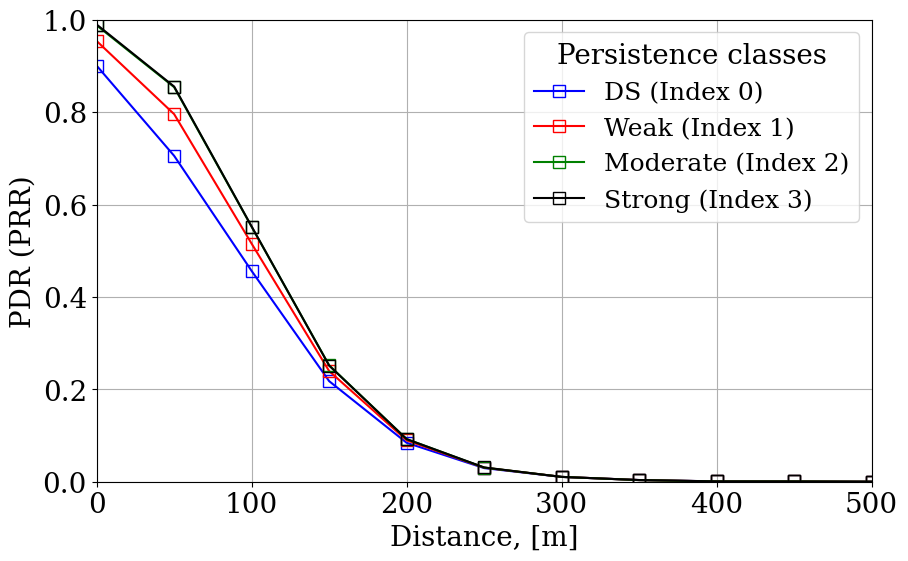

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


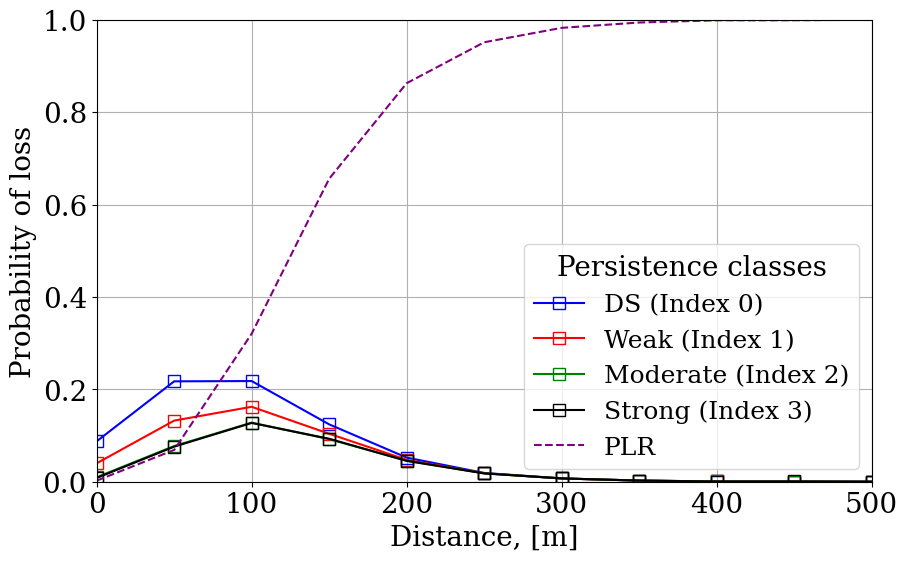

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


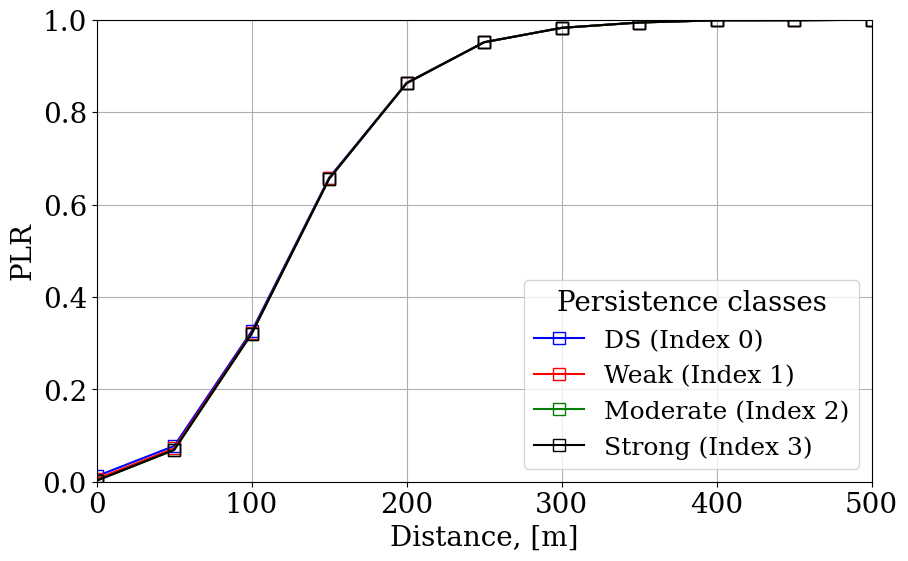

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


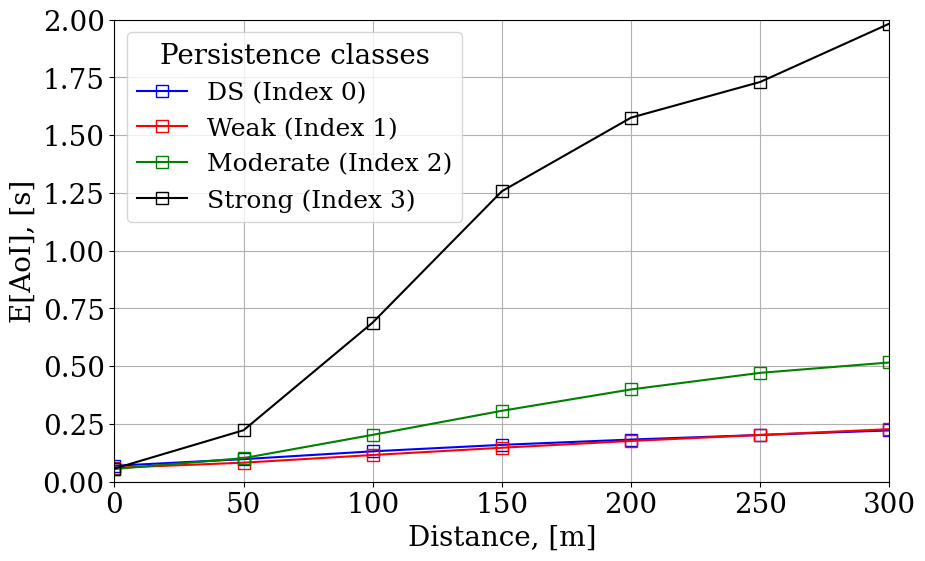

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


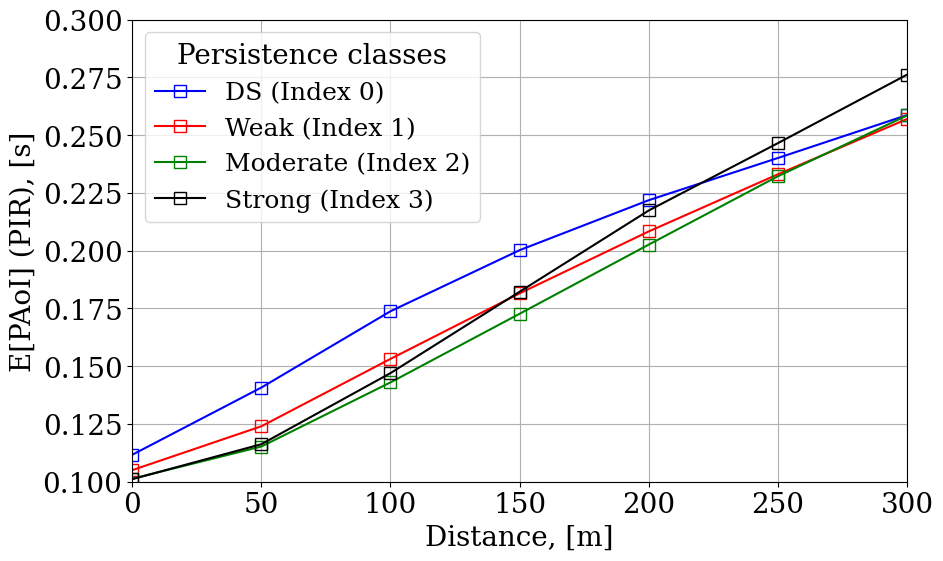

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

density = 700

# Read the CSV file
file_path = f'pp/{density}_metrics_pkeep_1.csv'
data = pd.read_csv(file_path, header=None)

# Add column names for easier reference
data.columns = ['mean PAoI (PIR)', 'mean AoI','index', 'distance', 'weight', 'pkeep', 'PDR (PRR)', 'CLR', 'PLR']

# Define the specific pkeep values to plot
pkeep_values = [0, 0.5, 0.95, 0.995]

# Define the metrics to plot
metrics = ['PDR (PRR)', 'CLR', 'PLR', 'mean AoI', 'mean PAoI (PIR)']

# Define the smoothing function
def smooth_data(series, window_size=5):
    return series.rolling(window=window_size, min_periods=1).mean()

# Define colors for different pkeep values
colors = ['blue', 'red', 'green', 'black']

# Define the labels for each pkeep value
labels = ['DS (Index 0)', 'Weak (Index 1)', 'Moderate (Index 2)', 'Strong (Index 3)']

# Create a plot for each metric
for metric in metrics:
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 20  # Set the default font size for all text in the figure
    plt.rcParams['legend.fontsize'] = '18'  # Set the legend font size
    plt.figure(figsize=(10, 6))
    plt.ylabel(metric)
    
    for i, pkeep in enumerate(pkeep_values):
        subset = data[data['pkeep'] == pkeep].sort_values(by='distance')
        
        # Apply specific colors and labels
        plt.plot(subset['distance'], subset[metric], color=colors[i], label=f'{labels[i]}', marker='s', markersize = 8, markerfacecolor='none')
        
        # Special handling for CLR and PLR metrics
        if metric == "CLR" and pkeep == 0.995:
            plt.plot(subset['distance'], subset['PLR'], label=f'PLR', color='purple', linestyle='--')

    plt.xlim(0, 300)
    plt.xlabel('Distance, [m]')
    
    # Set y-axis limits and labels for specific metrics
    if metric in ['PDR (PRR)', 'CLR', 'PLR']:
        plt.ylim([0, 1])
        plt.xlim(0, 500)
    if metric == 'CLR':
        plt.ylabel("Probability of loss")
    if metric == 'mean AoI':
        plt.ylim([0, 2])
        plt.ylabel('E[AoI], [s]')
    if metric == 'mean PAoI (PIR)':
        plt.ylim([0.1, 0.3])
        plt.ylabel('E[PAoI] (PIR), [s]')
    
    plt.legend(loc='best', title='Persistence classes')
    plt.grid(True)
    plt.savefig(f'figures/{density}_{metric}_vs_distance.eps', format='eps')
    plt.show()


In [27]:
import pandas as pd
import numpy as np

rho = 175
RC = 1

if RC == 1:
    avg_RC = 1
else:
    avg_RC = 10

df = pd.read_csv(f'pp/{rho}_metrics_pkeep_{RC}.csv', names=['mean_paoi','mean_aoi','region_id',"max_distance", 'weight','pkeep','pdr','clr','plr'])
df = df.dropna()
parameter_range = ['0.000000', '0.100000', '0.200000', '0.300000', '0.400000', '0.500000', '0.600000', '0.700000', '0.800000', '0.900000', '0.950000','0.975000','0.983333','0.987500','0.990000','0.993333','0.995000']

distance_region = [1,3,5,7]

df_avg_metrics = pd.DataFrame(columns=['parameter','mean_PDR',"mean_CLR",'mean_PLR','mean_PAoI','mean_AoI'])
df.astype(float)
df_avg_metrics.astype(float)

for j in distance_region:
    for i in parameter_range:
        test_df = df[(df['pkeep'] == float(i)) & (df['region_id'] <= j) & (df['region_id'] > j-2)]
        if not test_df.empty:
            new_row = {
                'parameter': i,
                'mean_PDR': test_df['pdr'].mean(),
                'mean_CLR': test_df['clr'].mean(),
                'mean_PLR': test_df['plr'].mean(),
                'mean_PAoI': test_df['mean_paoi'].mean(),
                'mean_AoI': test_df['mean_aoi'].mean(),
                'RC': RC,  # If you want the average RC
                'eta': avg_RC / (1 - float(i)),
                'distance': j,
                'density': rho
            }
            new_rows = pd.DataFrame([new_row])
            df_avg_metrics = pd.concat([df_avg_metrics, new_rows], ignore_index=True)

df_avg_metrics.to_csv("pp/avg_metrics_parameter_regions_dens.csv", mode='a', header=False, index=False)



Plot saved: figures/distance_1/mean_PDR_combined_vs_eta_d1.eps
Plot saved: figures/distance_1/mean_CLR_combined_vs_eta_d1.eps
Plot saved: figures/distance_1/mean_PLR_combined_vs_eta_d1.eps
Plot saved: figures/distance_1/mean_PAoI_combined_vs_eta_d1.eps
Plot saved: figures/distance_1/mean_AoI_combined_vs_eta_d1.eps
Plot saved: figures/distance_3/mean_PDR_combined_vs_eta_d3.eps
Plot saved: figures/distance_3/mean_CLR_combined_vs_eta_d3.eps
Plot saved: figures/distance_3/mean_PLR_combined_vs_eta_d3.eps
Plot saved: figures/distance_3/mean_PAoI_combined_vs_eta_d3.eps
Plot saved: figures/distance_3/mean_AoI_combined_vs_eta_d3.eps
Plot saved: figures/distance_5/mean_PDR_combined_vs_eta_d5.eps
Plot saved: figures/distance_5/mean_CLR_combined_vs_eta_d5.eps
Plot saved: figures/distance_5/mean_PLR_combined_vs_eta_d5.eps
Plot saved: figures/distance_5/mean_PAoI_combined_vs_eta_d5.eps
Plot saved: figures/distance_5/mean_AoI_combined_vs_eta_d5.eps
Plot saved: figures/distance_7/mean_PDR_combined_vs_

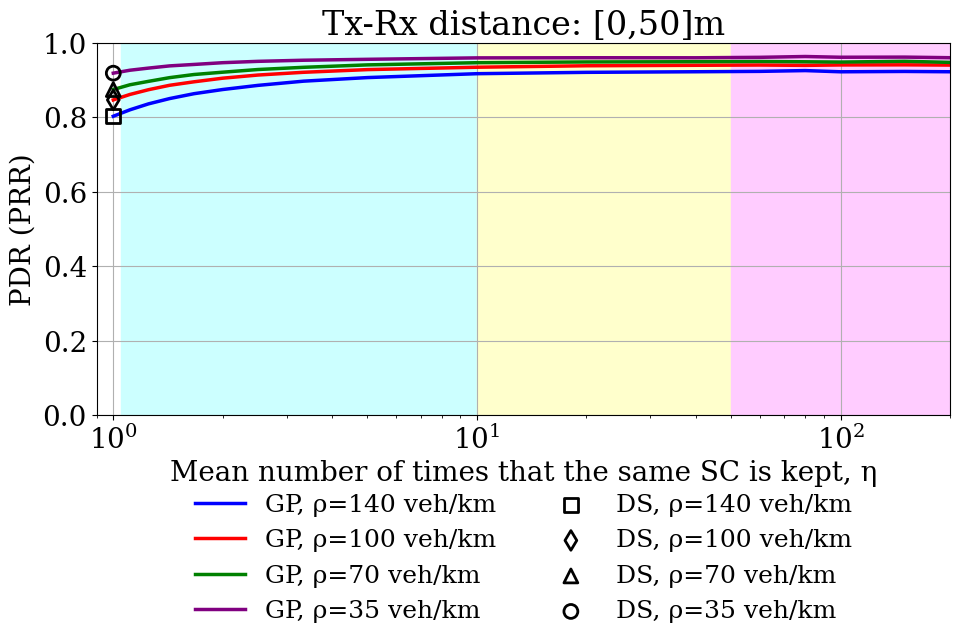

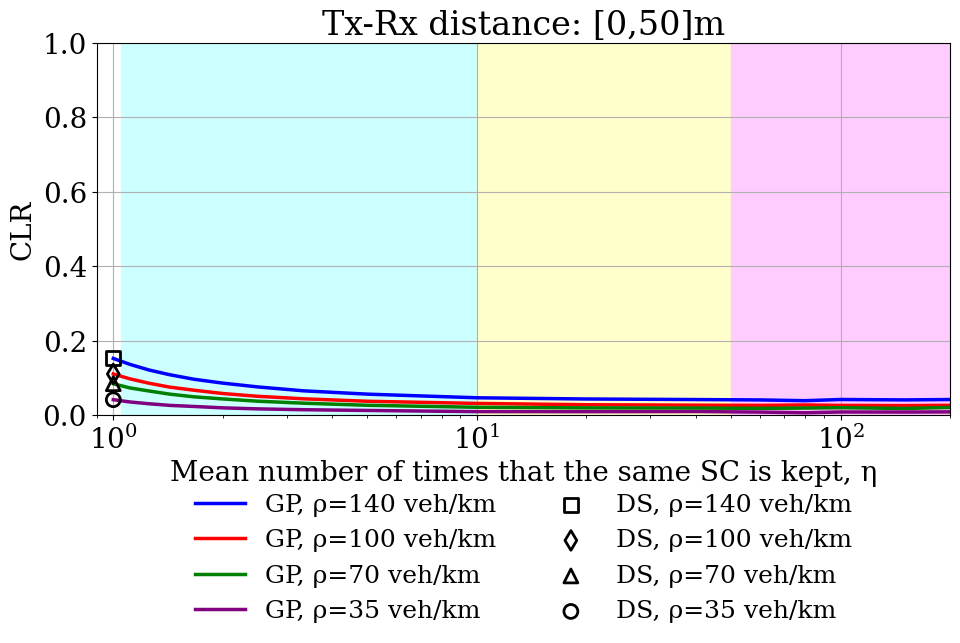

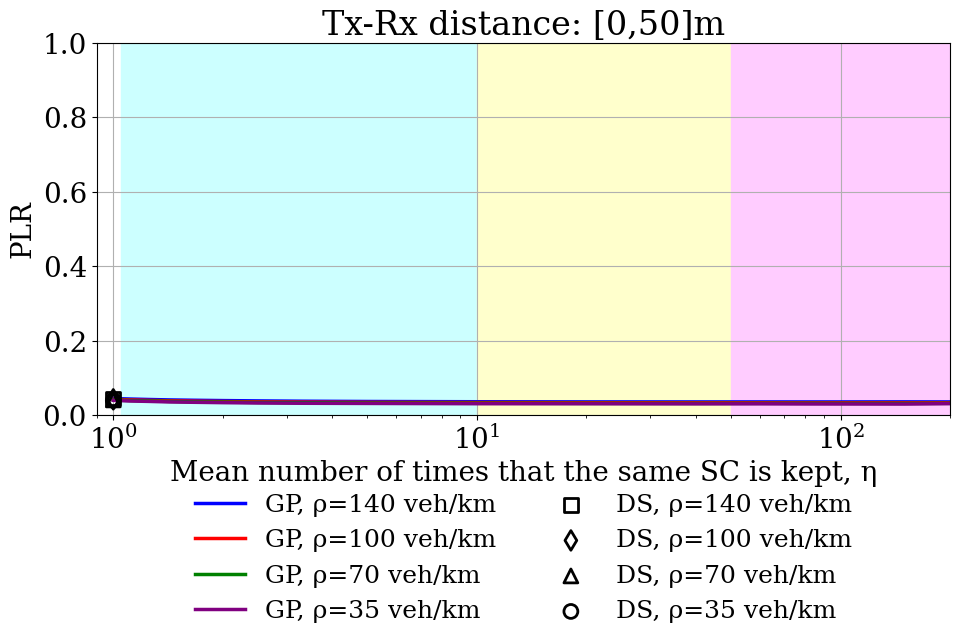

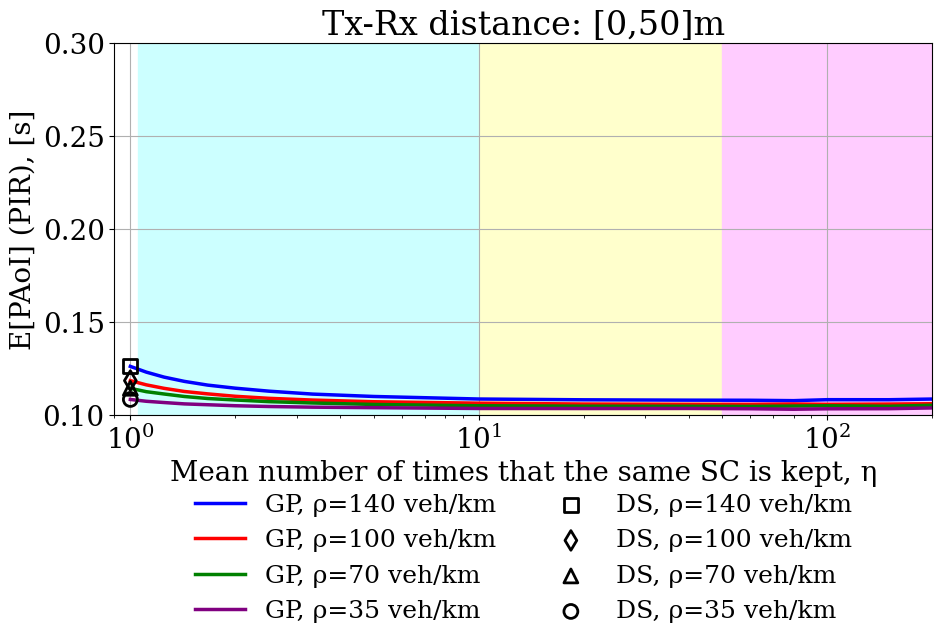

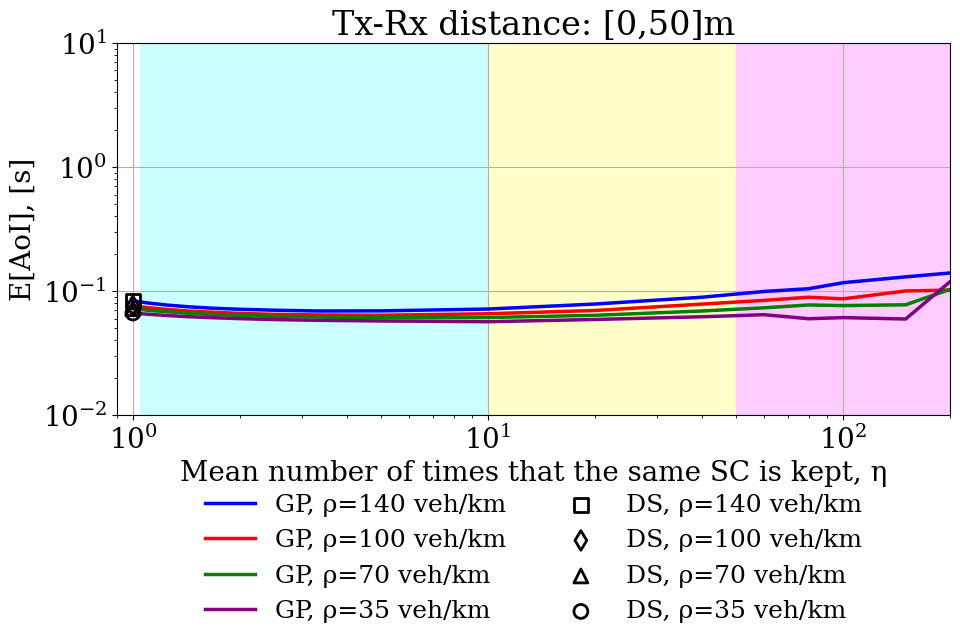

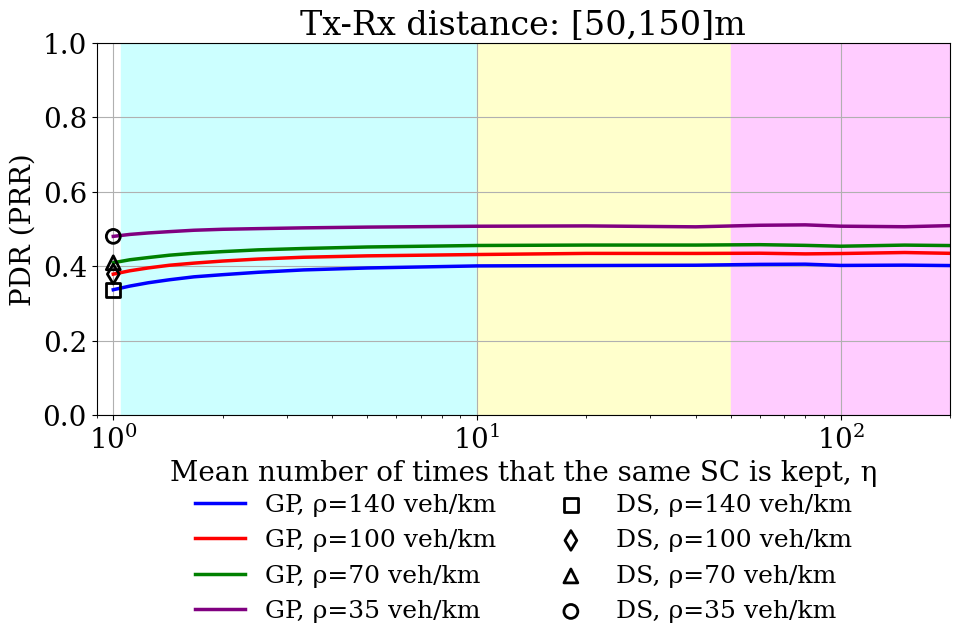

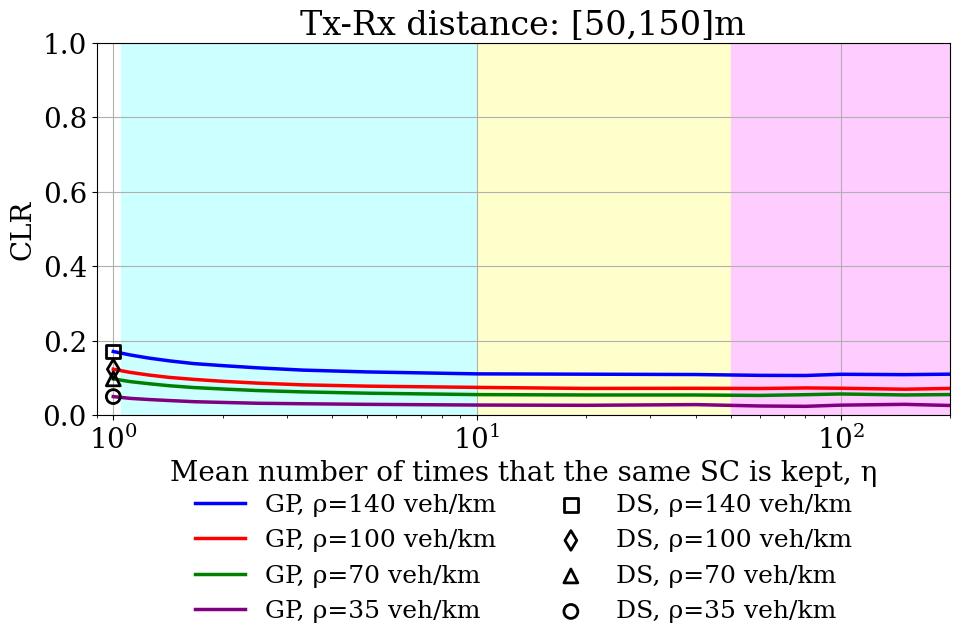

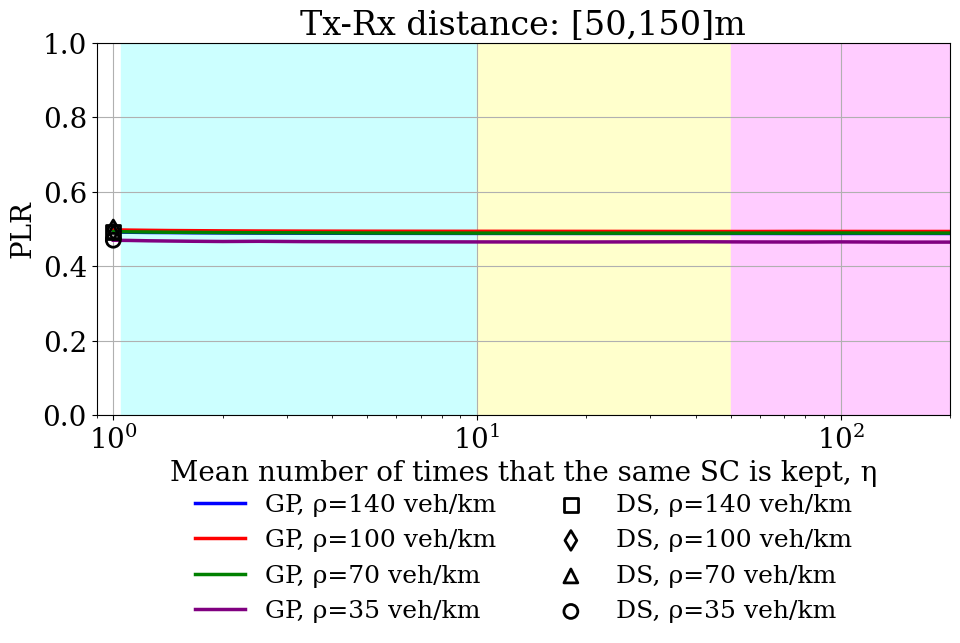

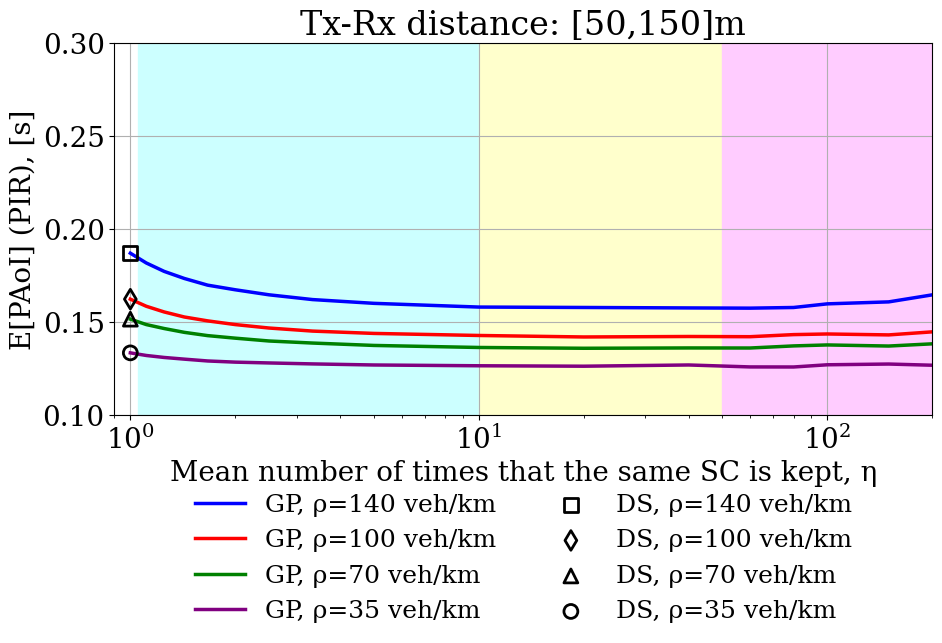

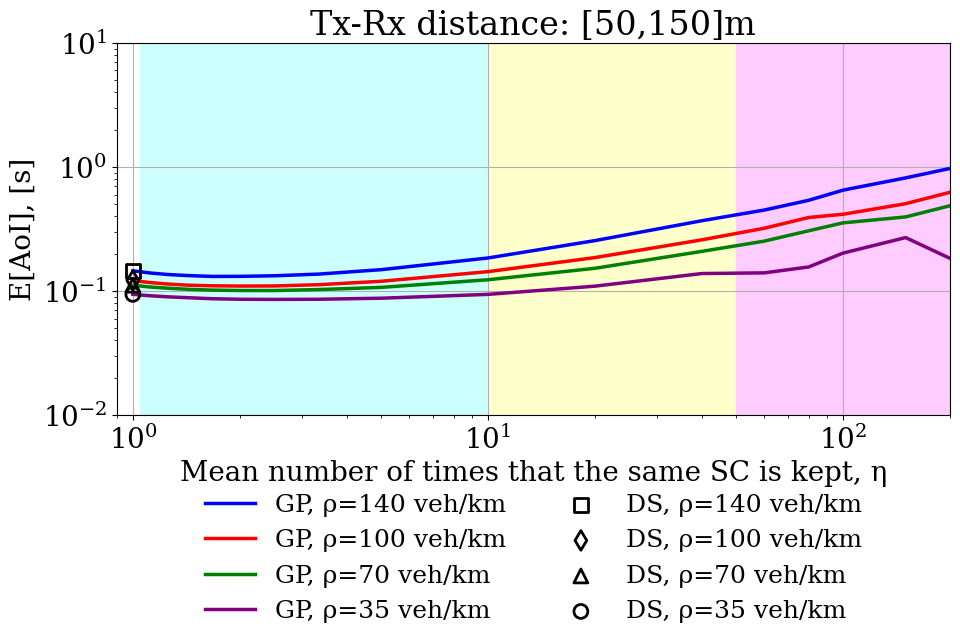

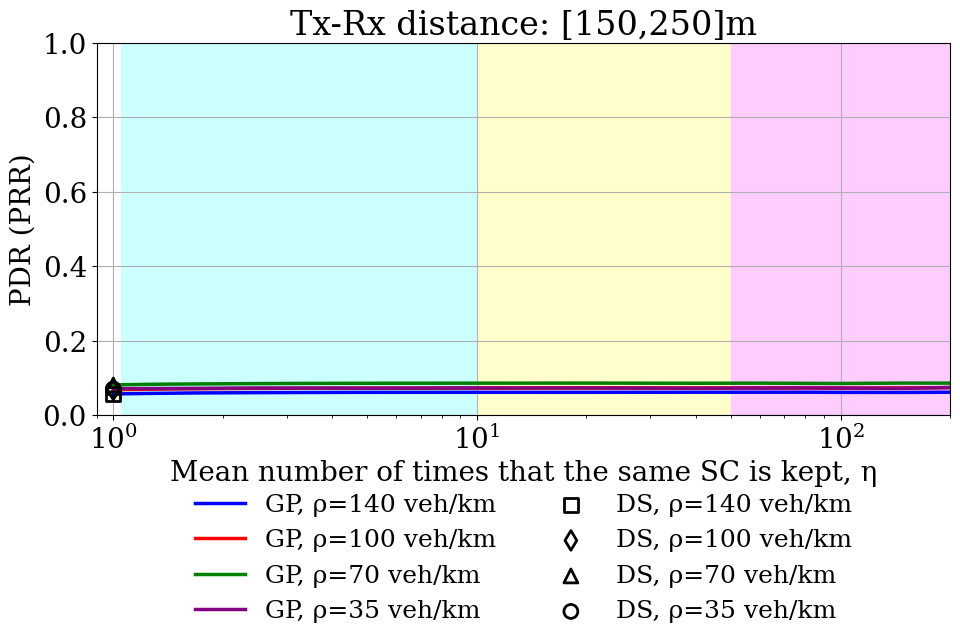

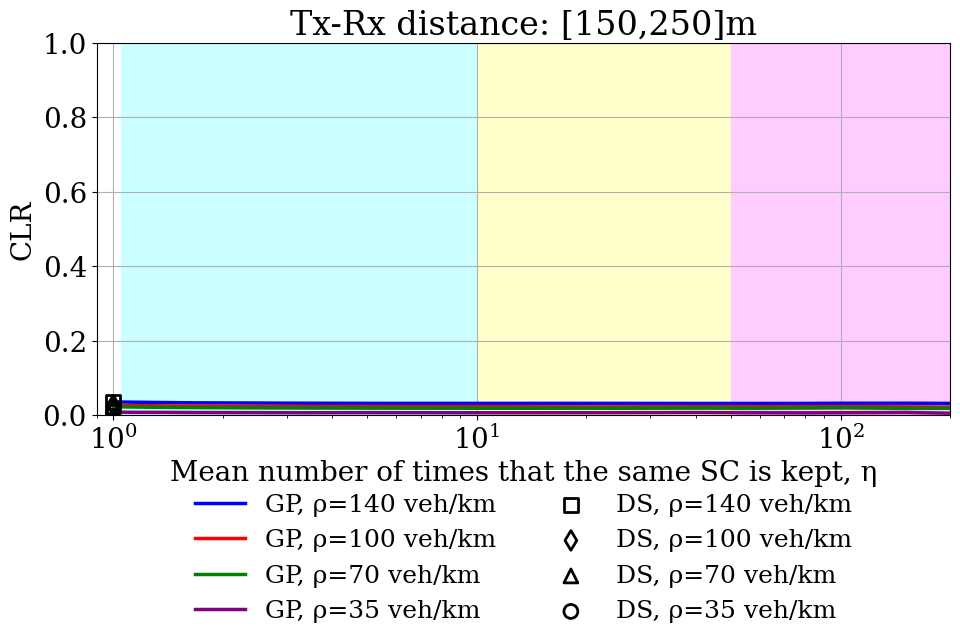

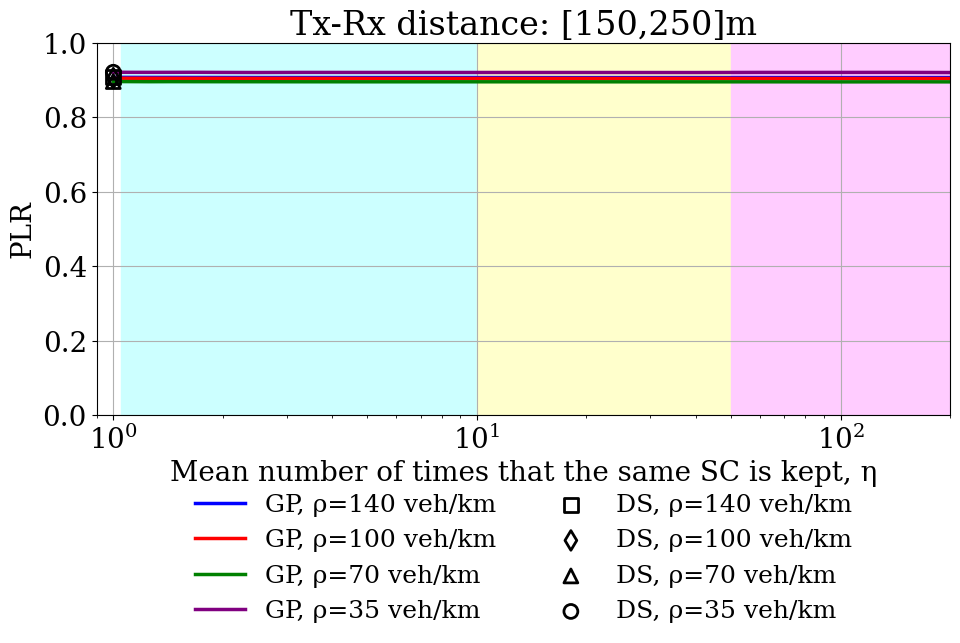

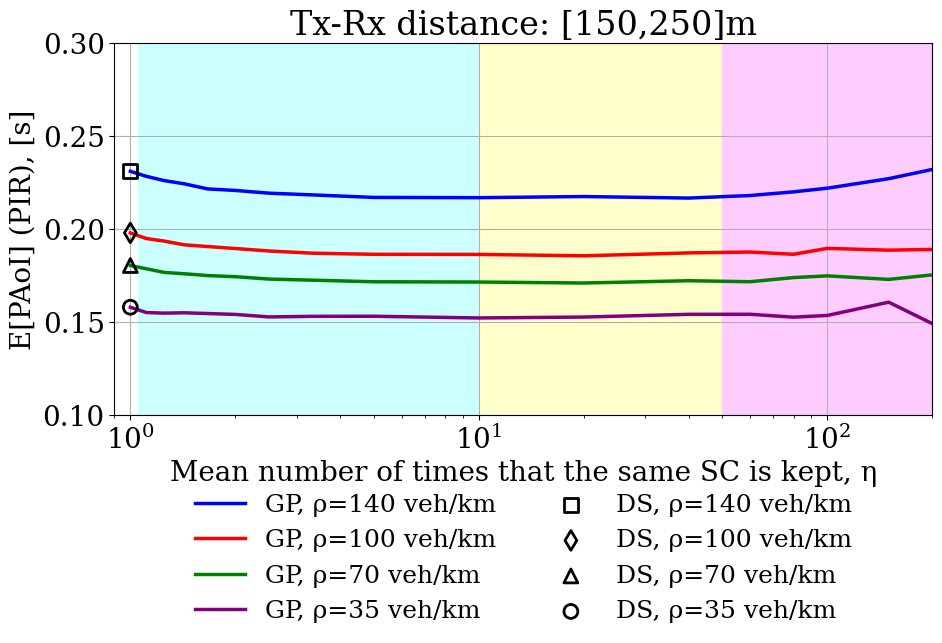

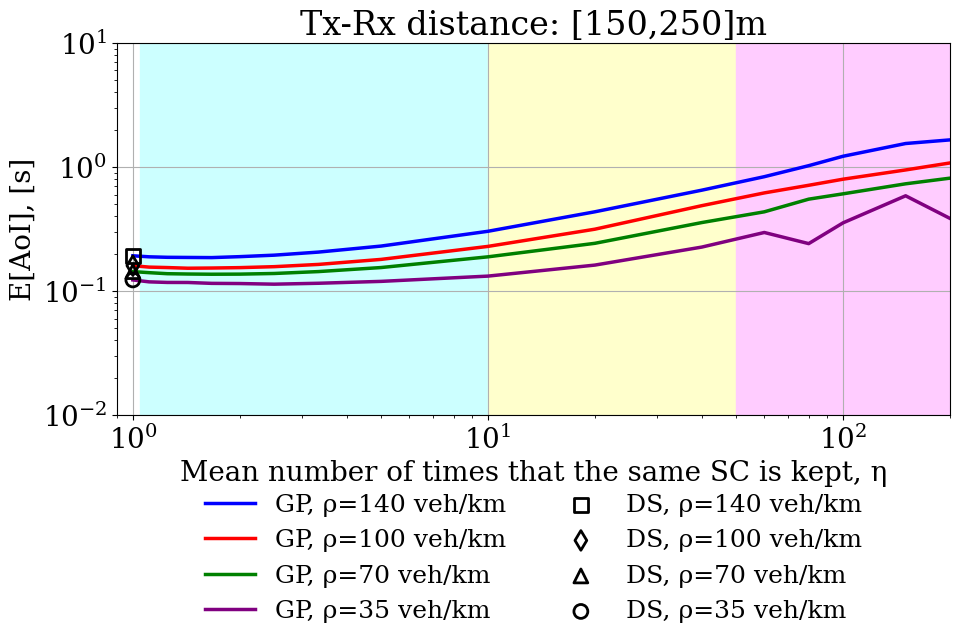

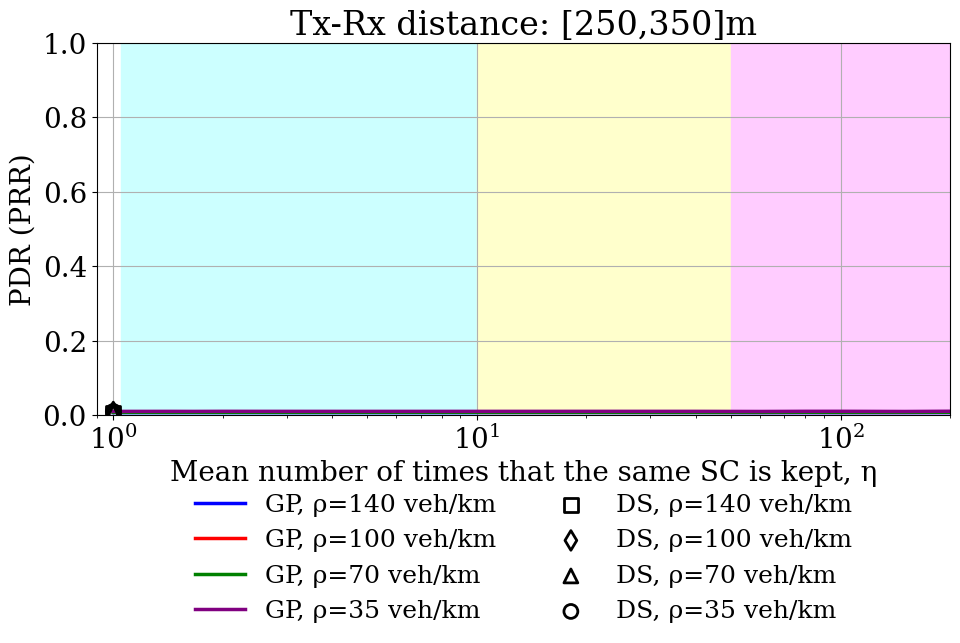

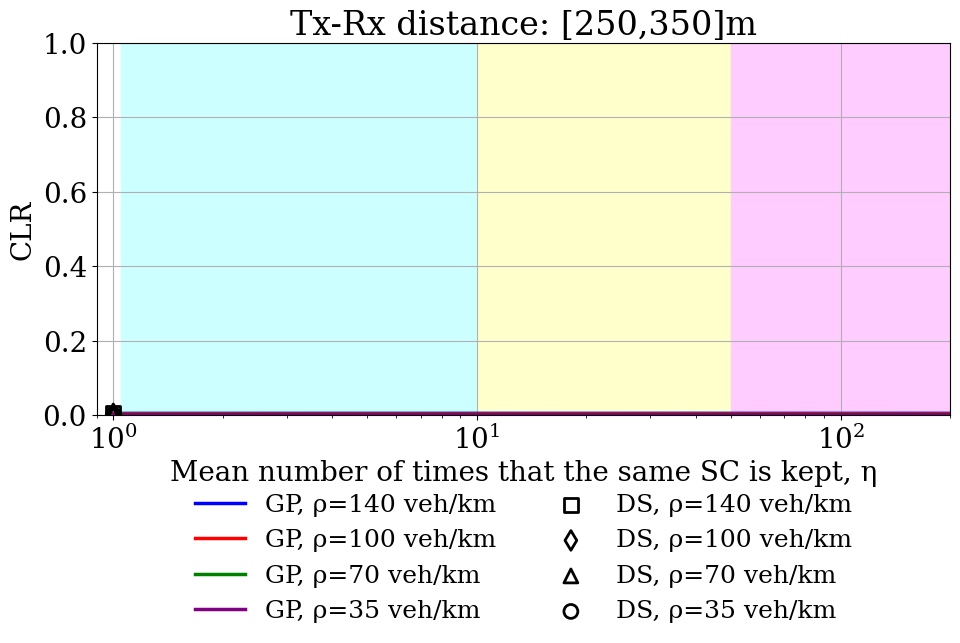

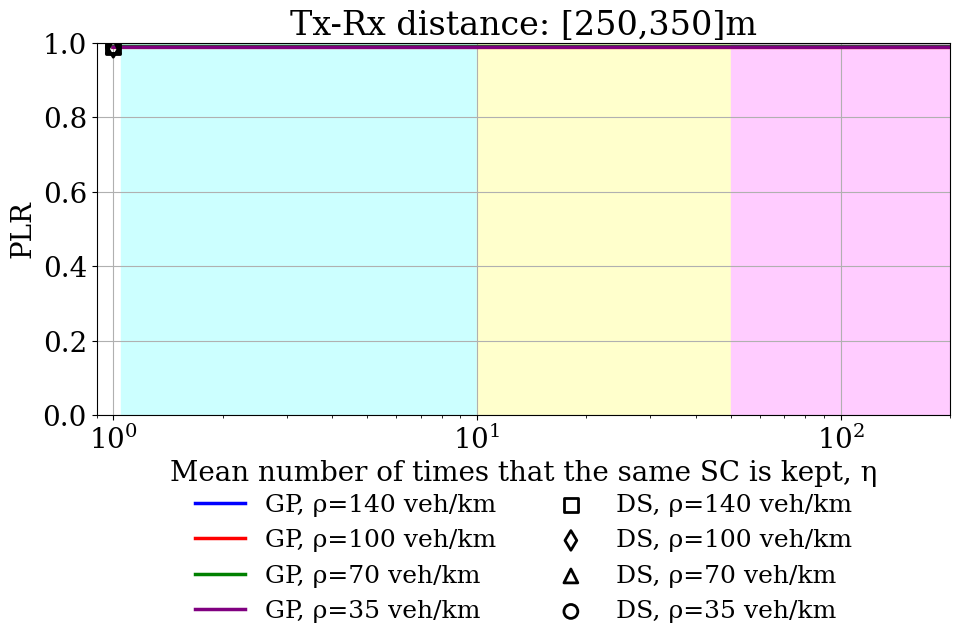

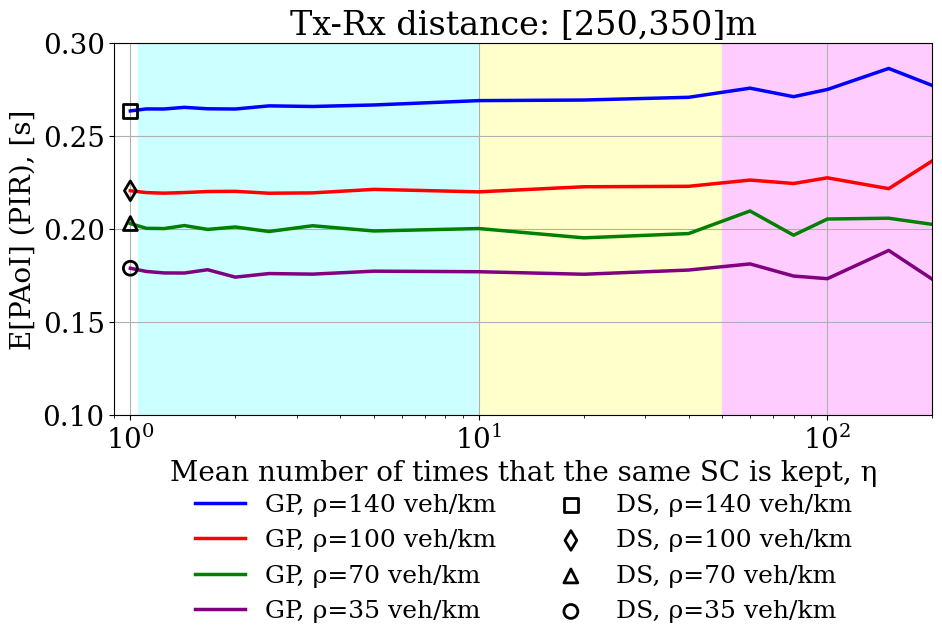

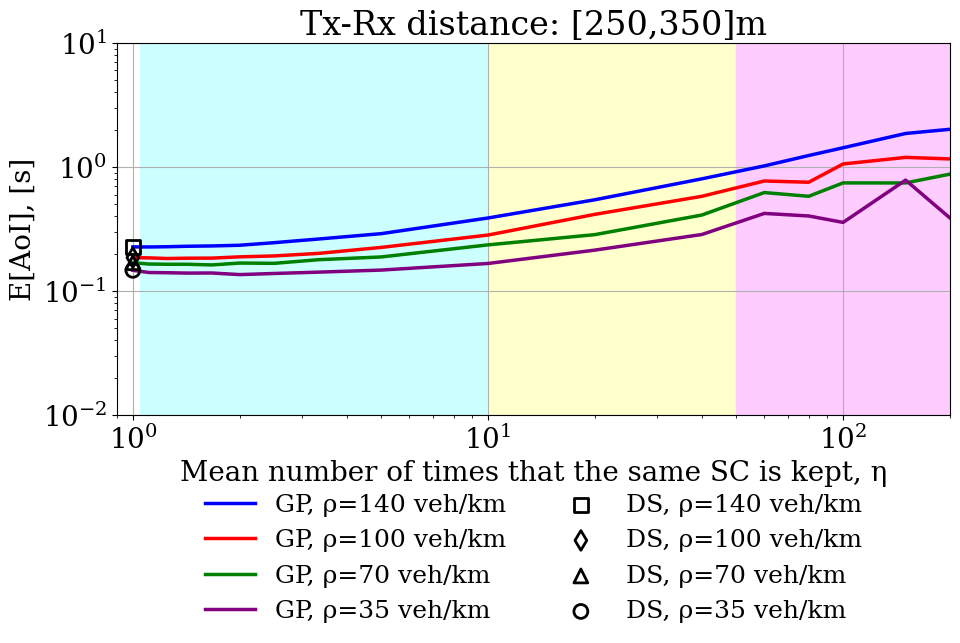

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator
import os

def plot_metrics_combined(dfs, labels, colors, linetypes, markers, markers_scatter, metric, title, ylabel_suffix, ylims, dens, dist, save_path=None):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = '18'  # Smaller font size for legends
    
    fig, ax = plt.subplots(figsize=(10, 8))
    added_labels = []  # Track added labels to avoid duplicates
    
    for df, label, color, linetype, marker, marker_scatter in zip(dfs, labels, colors, linetypes, markers, markers_scatter):
        ax.plot(df['eta'], df[metric], marker=marker, markersize=10, color=color, linestyle=linetype, label=label, linewidth=2.5)
        
        # Add scatter point for parameter == 1 with density-specific label
        scatter_point = df[df['eta'] == 1]
        if not scatter_point.empty:
            density = scatter_point['density'].values[0]  # Get the density for this curve
            scatter_label = f"DS, ρ={density/5:.0f} veh/km"
            
            # Plot the scatter point for the current density
            ax.scatter(
                1, 
                scatter_point[metric].values[0], 
                color='black', 
                s=100, 
                zorder=5, 
                marker=marker_scatter,
                facecolors='none', 
                linewidths=2,
                label=scatter_label if scatter_label not in added_labels else None
            )
            added_labels.append(scatter_label)  # Mark this label as added
    
    if metric == 'mean_AoI':
        ax.set_yscale('log')
    
    ax.set_xlim(0.9, 200)
    ax.set_xscale('log')
    
    ax.set_ylim(ylims[0], ylims[1])  # Apply y-limits dynamically based on log scale
    ax.set_xlabel('Mean number of times that the same SC is kept, η')
    ax.set_ylabel(title + ylabel_suffix)
    ax.grid()
    
    # Extract legend handles and labels
    handles, legend_labels = ax.get_legend_handles_labels()
    
    # Sort legend by categories (DS, SPS, Geometric)
    sorted_handles_labels = sorted(zip(handles, legend_labels), key=lambda hl: (
        "DS" in hl[1],  # Prioritize DS entries
        "SPS" in hl[1], # Then SPS entries
        "GP" in hl[1]  # Finally Geometric entries
    ))
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)
    ax.set_title(f'Tx-Rx distance: [{max(0, (dist*50 - 100))},{int(dist*50)}]m')
    ax.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2,frameon=False)
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit legend below plot
    
    # Highlight regions
    plt.axvspan(1.05, 10, color='#CCFFFF', label='')     # Green region
    plt.axvspan(10, 50, color='#FFFFCC', label='')   # Light blue region
    plt.axvspan(50, 200, color='#FFCCFF', label='')  # Peach region

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plot_file_path = f"{save_path}/{metric}_combined_vs_eta_d{dist}.eps"
        fig.savefig(plot_file_path, bbox_inches='tight')
        print(f"Plot saved: {plot_file_path}")



# Read the CSV file into a DataFrame
names = ['parameter', 'mean_PDR', 'mean_CLR', 'mean_PLR', 'mean_PAoI', 'mean_AoI', 'RC', 'eta', 'distance','density']
df_rc = pd.read_csv('pp/avg_metrics_parameter_regions_dens.csv', names=names)

metrics = ['mean_PDR', 'mean_CLR', 'mean_PLR', 'mean_PAoI', 'mean_AoI']
titles = ['PDR (PRR)', 'CLR', 'PLR', 'E[PAoI] (PIR)', 'E[AoI]']
ylabel_suffixes = ['', '', '', ', [s]', ', [s]']
ylims = [(0, 1), (0, 1), (0, 1), (0.1, 0.3), (0.01, 10)]  # Strictly positive limits for log scale

df_rc1 = df_rc[df_rc['RC'] == 1].sort_values(by=['density','distance', 'parameter'])
df_rc515 = df_rc[(df_rc['RC'] == 515) & (df_rc['parameter'] <= 0.8)]

distances = [1, 3, 5, 7]
densities = [700, 500, 350, 175]

colors_list = ['blue', 'red', 'green', 'purple']  # List of colors for densities

for d in distances:
    for i, metric in enumerate(metrics):
        # Lists to hold data, labels, and colors
        dfs = []
        labels = []
        colors = []  # List of colors for current lines
        linetypes = ['-']
        markers = ['', '']
        markers_scatter = ['s', 'd', '^', 'o']

        for idx, density in enumerate(densities):
            color = colors_list[idx % len(colors_list)]  # Cyclic color selection
            
            # Add lines for Geometric SPS
            df_density_rc1 = df_rc1[(df_rc1['distance'] == d) & (df_rc1['density'] == density)]
            if not df_density_rc1.empty:
                dfs.append(df_density_rc1)
                labels.append(f'GP, ρ={density/5:.0f} veh/km')
                colors.append(color)  # Add color for this line
            
            # Add lines for Standard SPS
            df_density_rc515 = df_rc515[(df_rc515['distance'] == d) & (df_rc515['density'] == density)]
            if not df_density_rc515.empty:
                dfs.append(df_density_rc515)
                labels.append(f'SPS, ρ={density/5:.0f} veh/km')
                colors.append(color)  # Same color for another type

        # Plot graphs
        plot_metrics_combined(
            dfs=dfs,
            labels=labels,
            colors=colors,
            linetypes=linetypes * len(densities),
            markers=markers * len(densities),
            metric=metric,
            markers_scatter=markers_scatter * len(densities),
            title=f'{titles[i]}',
            ylabel_suffix=ylabel_suffixes[i],
            ylims=ylims[i],
            dens=density,
            dist=d,
            save_path=f'figures/distance_{d}'
        )




Plot saved: figures/mean_PDR_dens_vs_eta.eps


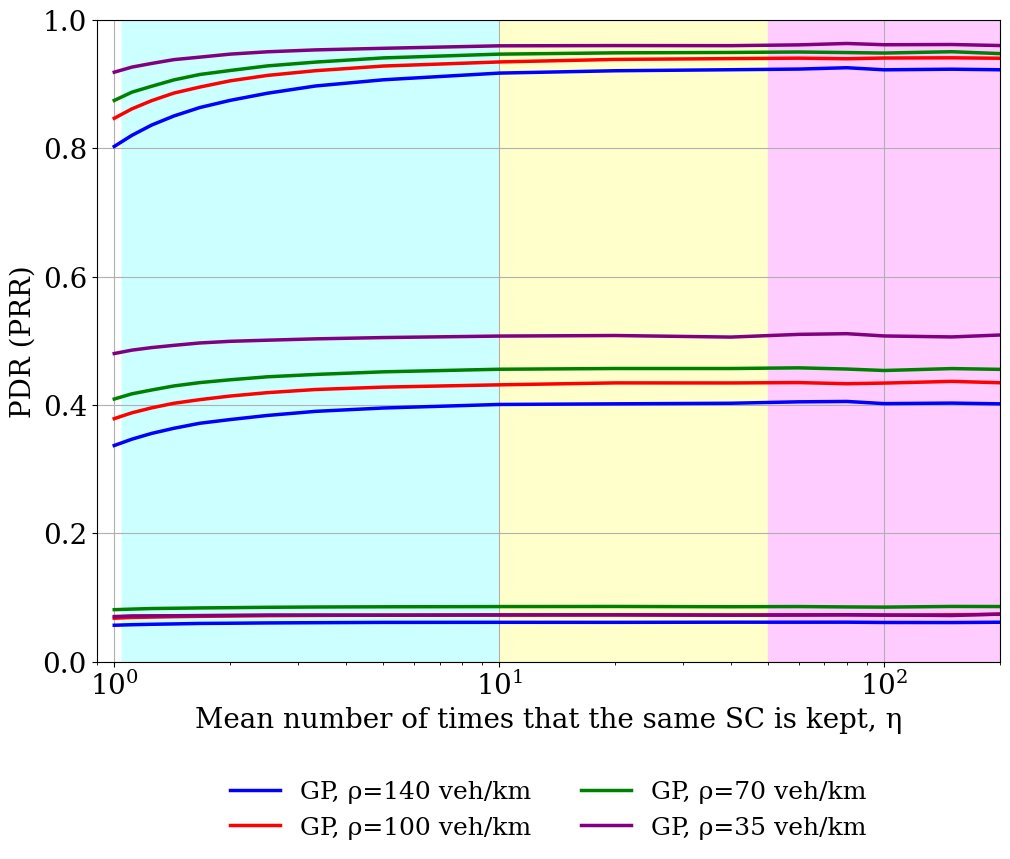

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator
import os

def plot_metrics_combined(dfs, labels, colors, linetypes, markers, markers_scatter, metric, title, ylabel_suffix, ylims, dens, dist, save_path=None):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = '18'  # Smaller font size for legends
    
    
    added_labels = []  # Track added labels to avoid duplicates
    
    for df, label, color, marker, marker_scatter in zip(dfs, labels, colors, markers, markers_scatter):
        ax.plot(df['eta'], df[metric], marker=marker, markersize=10, color=color, linestyle=linetypes, label=label, linewidth=2.5)
        '''
        # Add scatter point for parameter == 1 with density-specific label
        scatter_point = df[df['eta'] == 1]
        if not scatter_point.empty:
            density = scatter_point['density'].values[0]  # Get the density for this curve
            scatter_label = f"DS, ρ={density/5:.0f} veh/km"
            
            # Plot the scatter point for the current density
            ax.scatter(
                1, 
                scatter_point[metric].values[0], 
                color='black', 
                s=100, 
                zorder=5, 
                marker=marker_scatter,
                facecolors='none', 
                linewidths=2,
                label=scatter_label if scatter_label not in added_labels else None
            )
            added_labels.append(scatter_label)  # Mark this label as added
        '''
    if metric == 'mean_AoI':
        ax.set_yscale('log')
    
    ax.set_xlim(0.9, 200)
    ax.set_xscale('log')
    
    ax.set_ylim(ylims[0], ylims[1])  # Apply y-limits dynamically based on log scale
    ax.set_xlabel('Mean number of times that the same SC is kept, η')
    ax.set_ylabel(title + ylabel_suffix)
    
    
    # Extract legend handles and labels
    handles, legend_labels = ax.get_legend_handles_labels()
    
    # Sort legend by categories (DS, SPS, Geometric)
    sorted_handles_labels = sorted(zip(handles, legend_labels), key=lambda hl: (
        "DS" in hl[1],  # Prioritize DS entries
        "SPS" in hl[1], # Then SPS entries
        "GP" in hl[1]  # Finally Geometric entries
    ))
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)
    
    ax.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit legend below plot
    
    # Highlight regions
    plt.axvspan(1.05, 10, color='#CCFFFF', label='')     # Green region
    plt.axvspan(10, 50, color='#FFFFCC', label='')   # Light blue region
    plt.axvspan(50, 200, color='#FFCCFF', label='')  # Peach region

    



# Read the CSV file into a DataFrame
names = ['parameter', 'mean_PDR', 'mean_CLR', 'mean_PLR', 'mean_PAoI', 'mean_AoI', 'RC', 'eta', 'distance','density']
df_rc = pd.read_csv('pp/avg_metrics_parameter_regions_dens.csv', names=names)

metrics = ['mean_PDR']
titles = ['PDR (PRR)']
ylabel_suffixes = ['', '', '', ', [s]', ', [s]']
ylims = [(0, 1), (0, 1), (0, 1), (0, 0.4), (0.01, 10)]  # Strictly positive limits for log scale

df_rc1 = df_rc[df_rc['RC'] == 1].sort_values(by=['density','distance', 'parameter'])
df_rc515 = df_rc[(df_rc['RC'] == 515) & (df_rc['parameter'] <= 0.8)]

distances = [1, 3, 5, 7]
densities = [700, 500, 350, 175]

colors_list = ['blue', 'red', 'green', 'purple']  # List of colors for densities
fig, ax = plt.subplots(figsize=(10.5, 10))
ax.grid()
linetypes_all = ['-', '--','-.',':']

for idy, d in enumerate(distances):
    linetypes = linetypes_all[idy % len(linetypes_all)] 
    for i, metric in enumerate(metrics):
        # Lists to hold data, labels, and colors
        dfs = []
        labels = []
        colors = []  # List of colors for current lines
        
        markers = ['', '']
        markers_scatter = ['s', 'd', '^', 'o']

        for idx, density in enumerate(densities):
            color = colors_list[idx % len(colors_list)]  # Cyclic color selection
            
            # Add lines for Geometric SPS
            df_density_rc1 = df_rc1[(df_rc1['distance'] == d) & (df_rc1['density'] == density)]
            if not df_density_rc1.empty:
                dfs.append(df_density_rc1)
                labels.append(f'GP [{max(0, (d*50 - 100))},{int(d*50)}]m, ρ={density/5:.0f} veh/km')
                colors.append(color)  # Add color for this line
            
            # Add lines for Standard SPS
            #df_density_rc515 = df_rc515[(df_rc515['distance'] == d) & (df_rc515['density'] == density)]
            #if not df_density_rc515.empty:
            #    dfs.append(df_density_rc515)
            #    labels.append(f'SPS, ρ={density/5:.0f} veh/km')
            #    colors.append(color)  # Same color for another type

        # Plot graphs
        plot_metrics_combined(
            dfs=dfs,
            labels=labels,
            colors=colors,
            linetypes=linetypes,
            markers=markers * len(densities),
            metric=metric,
            markers_scatter=markers_scatter * len(densities),
            title=f'{titles[i]}',
            ylabel_suffix=ylabel_suffixes[i],
            ylims=ylims[i],
            dens=density,
            dist=d,
            save_path=f'figures/distance_{d}'
        )


  
plot_file_path = f"figures/{metric}_dens_vs_eta.eps"
fig.savefig(plot_file_path, bbox_inches='tight')
print(f"Plot saved: {plot_file_path}")


Plot saved: figures/mean_PDR_dens_vs_eta.pdf


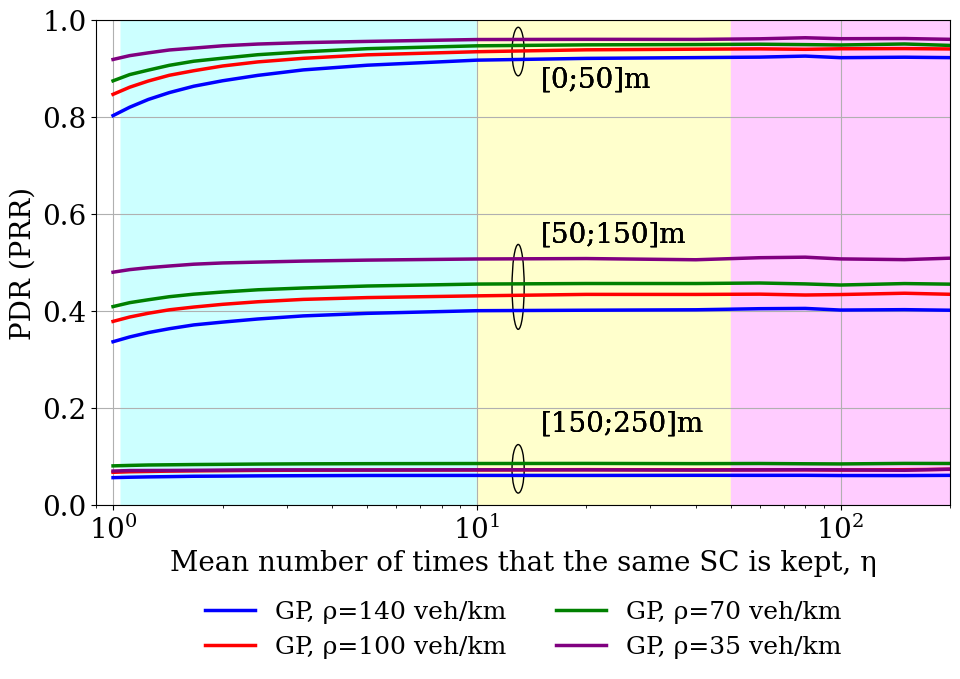

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Ellipse
import os


def plot_metrics_combined(dfs, labels, colors, linetypes, markers, markers_scatter, metric, title, ylabel_suffix, ylims, dens, dist, save_path=None):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = '18'  # Размер шрифта легенды

    added_labels = []  # Список для отслеживания добавленных меток

    for df, label, color, marker, marker_scatter in zip(dfs, labels, colors, markers, markers_scatter):
        plot_label = label if label not in added_labels else None
        if plot_label:
            added_labels.append(label)
        
        ax.plot(
            df['eta'], df[metric], marker=marker, markersize=10, color=color, 
            linestyle=linetypes, label=plot_label, linewidth=2.5
        )

    if metric == 'mean_AoI':
        ax.set_yscale('log')
    
    ax.set_xlim(0.9, 200)
    ax.set_xscale('log')
    
    ax.set_ylim(ylims[0], ylims[1])  # Устанавливаем динамические пределы по оси Y
    ax.set_xlabel('Mean number of times that the same SC is kept, η')
    ax.set_ylabel(title + ylabel_suffix)
    
    
    
    # Уникальные значения для легенды
    handles, legend_labels = ax.get_legend_handles_labels()
    unique_handles_labels = list(dict(zip(legend_labels, handles)).items())
    sorted_labels, sorted_handles = zip(*unique_handles_labels)
    
    ax.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
    plt.tight_layout(rect=[0, 0.1, 1, 1])

     # Highlight regions
    plt.axvspan(1.05, 10, color='#CCFFFF', label='')     # Green region
    plt.axvspan(10, 50, color='#FFFFCC', label='')   # Light blue region
    plt.axvspan(50, 200, color='#FFCCFF', label='')  # Peach region

    # Рисуем прозрачные овалы и добавляем текст
    ellipses = [
        {"ellipse": Ellipse((13, 0.935), width=1, height=0.1, edgecolor='black', facecolor='none', linestyle='-'),
         "text": "[0;50]m", "text_pos": (15, 0.85)},  # Овал 1
        {"ellipse": Ellipse((13, 0.45), width=1, height=0.175, edgecolor='black', facecolor='none', linestyle='-'),
         "text": "[50;150]m", "text_pos": (15, 0.53)},  # Овал 2
        {"ellipse": Ellipse((13, 0.075), width=1, height=0.1, edgecolor='black', facecolor='none', linestyle='-'),
         "text": "[150;250]m", "text_pos": (15, 0.14)}  # Овал 3
    ]
    for e in ellipses:
        ax.add_patch(e["ellipse"])  # Добавляем овал на график
        plt.text(
            e["text_pos"][0], e["text_pos"][1], e["text"], 
            color=e["ellipse"].get_edgecolor(), 
            ha='left', va='bottom'  # Текст снизу справа
        )




    



# Read the CSV file into a DataFrame
names = ['parameter', 'mean_PDR', 'mean_CLR', 'mean_PLR', 'mean_PAoI', 'mean_AoI', 'RC', 'eta', 'distance','density']
df_rc = pd.read_csv('pp/avg_metrics_parameter_regions_dens.csv', names=names)

metrics = ['mean_PDR']
titles = ['PDR (PRR)']
ylabel_suffixes = ['', '', '', ', [s]', ', [s]']
ylims = [(0, 1), (0, 1), (0, 1), (0, 0.4), (0.01, 10)]  # Strictly positive limits for log scale

df_rc1 = df_rc[df_rc['RC'] == 1].sort_values(by=['density','distance', 'parameter'])
df_rc515 = df_rc[(df_rc['RC'] == 515) & (df_rc['parameter'] <= 0.8)]

distances = [1, 3, 5]
densities = [700, 500, 350, 175]

colors_list = ['blue', 'red', 'green', 'purple']  # List of colors for densities
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()
linetypes_all = ['-']

for idy, d in enumerate(distances):
    linetypes = linetypes_all[idy % len(linetypes_all)] 
    for i, metric in enumerate(metrics):
        # Lists to hold data, labels, and colors
        dfs = []
        labels = []
        colors = []  # List of colors for current lines
        
        markers = ['', '']
        markers_scatter = ['s', 'd', '^', 'o']

        for idx, density in enumerate(densities):
            color = colors_list[idx % len(colors_list)]  # Cyclic color selection
            
            # Add lines for Geometric SPS
            df_density_rc1 = df_rc1[(df_rc1['distance'] == d) & (df_rc1['density'] == density)]
            if not df_density_rc1.empty:
                dfs.append(df_density_rc1)
                labels.append(f'GP, ρ={density/5:.0f} veh/km')
                colors.append(color)  # Add color for this line
            
            # Add lines for Standard SPS
            #df_density_rc515 = df_rc515[(df_rc515['distance'] == d) & (df_rc515['density'] == density)]
            #if not df_density_rc515.empty:
            #    dfs.append(df_density_rc515)
            #    labels.append(f'SPS, ρ={density/5:.0f} veh/km')
            #    colors.append(color)  # Same color for another type
        labels = list(dict.fromkeys(labels))
        # Plot graphs
        plot_metrics_combined(
            dfs=dfs,
            labels=labels,
            colors=colors,
            linetypes=linetypes,
            markers=markers * len(densities),
            metric=metric,
            markers_scatter=markers_scatter * len(densities),
            title=f'{titles[i]}',
            ylabel_suffix=ylabel_suffixes[i],
            ylims=ylims[i],
            dens=density,
            dist=d,
            save_path=f'figures/distance_{d}'
        )

# [{max(0, (d*50 - 100))},{int(d*50)}]m

  
plot_file_path = f"figures/{metric}_dens_vs_eta.pdf"
fig.savefig(plot_file_path, bbox_inches='tight', format='pdf', dpi=300)
print(f"Plot saved: {plot_file_path}")


Plot saved: figures/mean_PDR_combined_vs_eta_regions.eps
Plot saved: figures/mean_CLR_combined_vs_eta_regions.eps
Plot saved: figures/mean_PLR_combined_vs_eta_regions.eps
Plot saved: figures/mean_PAoI_combined_vs_eta_regions.eps
Plot saved: figures/mean_AoI_combined_vs_eta_regions.eps


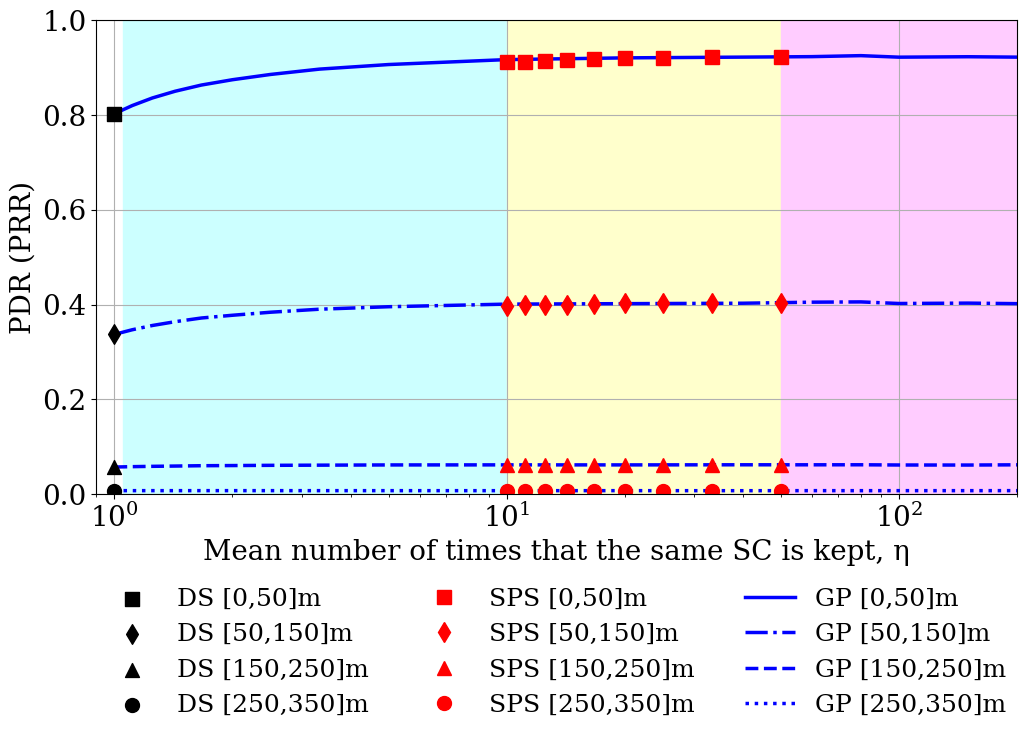

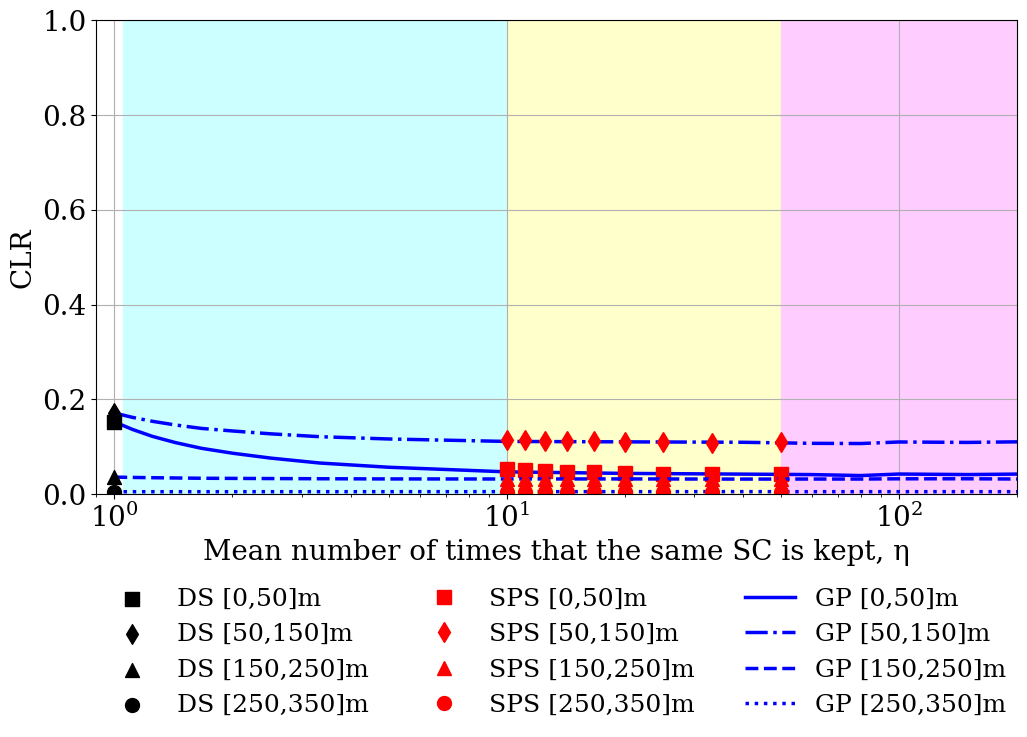

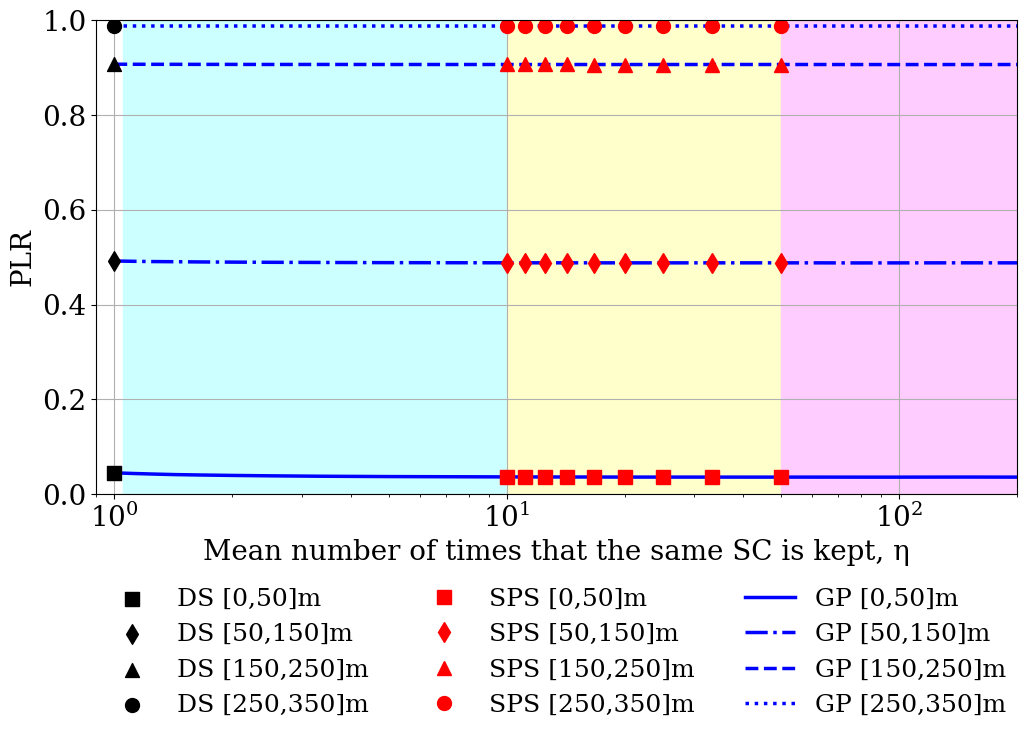

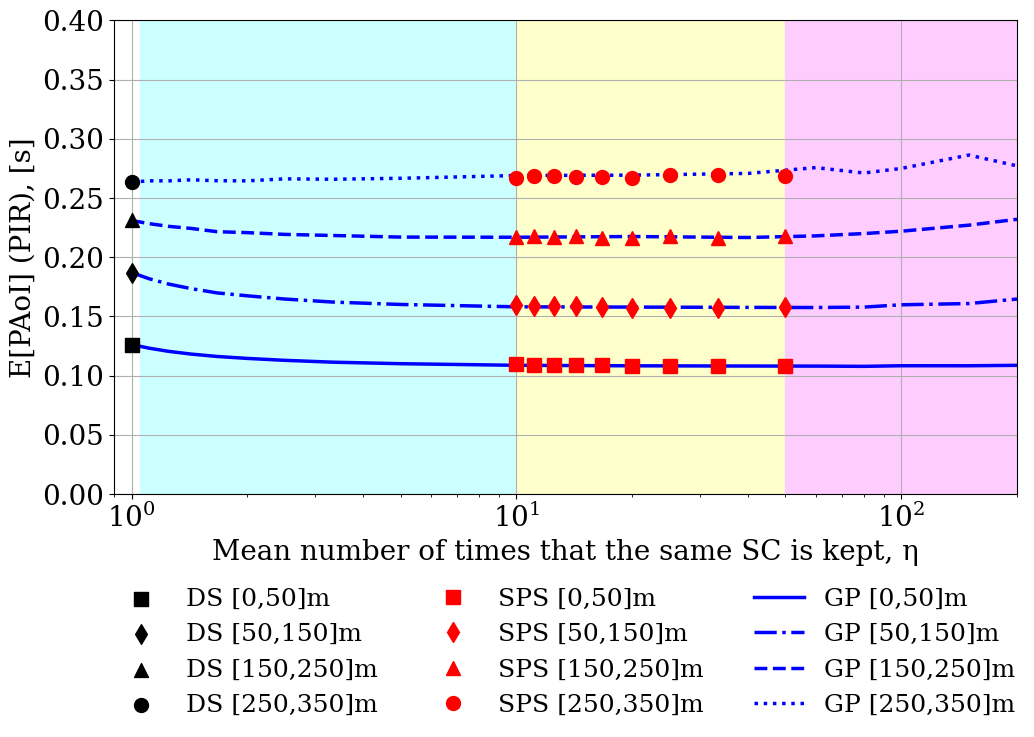

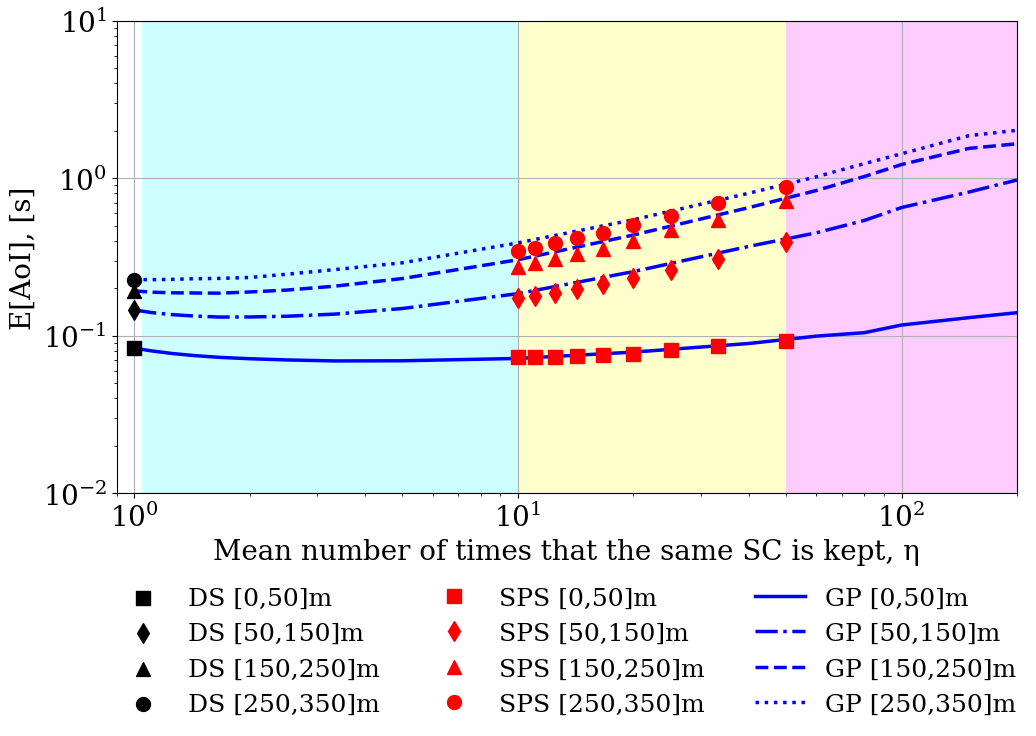

In [11]:
def plot_metrics_combined(dfs, labels, labels_dist, colors, linetypes, markers, markers_scatter, metric, title, ylabel_suffix, ylims, save_path=None):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = '18'
    
    fig, ax = plt.subplots(figsize=(11,9))
    
    for df, label, dist_label, color, linetype, marker, marker_scatter in zip(dfs, labels, labels_dist, colors, linetypes, markers, markers_scatter):
        ax.plot(df['eta'], df[metric], marker=marker, markersize=10, color=color, linestyle=linetype, label=label, linewidth=2.5)
        
        # Add scatter point for parameter == 1
        scatter_point = df[df['eta'] == 1]
        if not scatter_point.empty:
            ax.scatter(
                1, 
                scatter_point[metric].values[0], 
                color='black', 
                s=100, 
                zorder=5, 
                marker=marker_scatter, 
                label=dist_label
            )

        if metric == 'mean_AoI':
            ax.set_yscale('log')
    
    ax.set_xlim(0.9, 200)
    ax.set_xscale('log')
    
    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlabel('Mean number of times that the same SC is kept, η')
    ax.set_ylabel(title + ylabel_suffix)
    ax.grid()
    
    # Extract legend handles and labels
    handles, legend_labels = ax.get_legend_handles_labels()
    
    # Group legend by categories: DS, SPS, Geometric persistence
    grouped_legend = {"DS": [], "SPS": [], "GP": []}
    for handle, label in zip(handles, legend_labels):
        if "DS" in label:
            grouped_legend["DS"].append((handle, label))
        elif "SPS" in label:
            grouped_legend["SPS"].append((handle, label))
        elif "GP" in label:
            grouped_legend["GP"].append((handle, label))

    # Flatten the grouped handles and labels in column order
    sorted_handles = []
    sorted_labels = []
    for key in ["DS", "SPS", "GP"]:
        for handle, label in grouped_legend[key]:
            sorted_handles.append(handle)
            sorted_labels.append(label)
    
    # Create the legend with 3 columns
    ax.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    
    # Highlight regions
    plt.axvspan(1.05, 10, color='#CCFFFF', label='')
    plt.axvspan(10, 50, color='#FFFFCC', label='')
    plt.axvspan(50, 200, color='#FFCCFF', label='')

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plot_file_path = f"{save_path}/{metric}_combined_vs_eta_regions.eps"
        fig.savefig(plot_file_path, bbox_inches='tight')
        print(f"Plot saved: {plot_file_path}")


# Read the CSV file into a DataFrame
names = ['parameter', 'mean_PDR', 'mean_CLR', 'mean_PLR', 'mean_PAoI', 'mean_AoI', 'RC', 'eta', 'distance','density']
df_rc = pd.read_csv('pp/avg_metrics_parameter_regions_dens_full_test.csv', names=names)

metrics = ['mean_PDR', 'mean_CLR', 'mean_PLR', 'mean_PAoI', 'mean_AoI']
titles = ['PDR (PRR)', 'CLR', 'PLR', 'E[PAoI] (PIR)', 'E[AoI]']
ylabel_suffixes = ['', '', '', ', [s]', ', [s]']
ylims = [(0, 1), (0, 1), (0, 1), (0, 0.4), (0.01, 10)]  # Strictly positive limits for log scale

df_rc1 = df_rc[df_rc['RC'] == 1].sort_values(by=['distance', 'parameter'])
df_rc515 = df_rc[(df_rc['RC'] == 515) & (df_rc['parameter'] <= 0.8)]



distances = [1,3,5,7]

for i, metric in enumerate(metrics):
    dfs = []
    labels = []
    labels_dist = []
    colors = ['blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red']
    linetypes = ['-', '', '-.', '', '--', '', ':', '']
    markers = ['', 's', '', 'd', '', '^', '', 'o']
    markers_scatter = ['s', 's', 'd', 'd', '^', '^', 'o', 'o']
    
    for d in distances:
        dfs.append(df_rc1[df_rc1['distance'] == d])
        labels.append(f'GP [{max(0, (d*50 - 100))},{int(d*50)}]m')
        labels_dist.append(f'DS [{max(0, (d*50 - 100))},{int(d*50)}]m')
        
        dfs.append(df_rc515[df_rc515['distance'] == d])
        labels.append(f'SPS [{max(0, (d*50 - 100))},{int(d*50)}]m')
        labels_dist.append(f'DS [{max(0, (d*50 - 100))},{int(d*50)}]m')

    plot_metrics_combined(
        dfs=dfs,
        labels=labels,
        labels_dist=labels_dist,
        colors=colors,
        linetypes=linetypes,
        markers=markers,
        markers_scatter=markers_scatter,
        metric=metric,
        title=titles[i],
        ylabel_suffix=ylabel_suffixes[i],
        ylims=ylims[i],
        save_path='figures'
    )


In [77]:
import modin.pandas as pd

density = 700

# Read the CSV file using Modin
df = pd.read_csv(f"pp/{density}_aoi_database_pkeep_1.csv", 
                 names=['txID', 'rxID', 'rxTime', 'distance', 'pir', 'pir_sqr', 'mean_pir', 'mean_pir_sqr', 'aoi', 'pkeep'])

# Remove duplicates
df = df.drop_duplicates()

RC_avg = 1
parameter_range = [
    '0.00', '0.10', '0.20', '0.30', '0.40', '0.50',
    '0.60', '0.70', '0.80', '0.90', '0.950000', 
    '0.975000', '0.983333', '0.987500', '0.99', 
    '0.993333', '0.995000'
]

distance_ranges = [(0, 50), (50, 150), (150, 250), (250, 350)]

# Initialize an empty list to store results
results = []

# Iterate over distance ranges and parameter range
for dist_min, dist_max in distance_ranges:
    for var_p in parameter_range:
        current_df = df[
            (df['pkeep'] == float(var_p)) &
            (df['distance'] >= dist_min) &
            (df['distance'] <= dist_max)
        ]
        quantile_90 = current_df['aoi'].quantile(0.9)
        
        # Append results
        results.append({
            'pkeep': var_p,
            'aoi_90th_quantile': quantile_90,
            'eta': RC_avg / (1 - float(var_p)),
            'RC_avg': RC_avg,
            'distance': dist_max,
            'density': density
        })

# Convert the results list into a Modin DataFrame
df_anomaly = pd.DataFrame(results)

# Save to CSV
df_anomaly.to_csv('pp/aoi_anomaly_dist_dens.csv', index=False, mode='a')

print("Anomaly data saved successfully to 'aoi_anomaly_dist.csv'.")


Anomaly data saved successfully to 'aoi_anomaly_dist.csv'.


Plot saved: figures/aoi_90th_quantile_combined_vs_eta_regions.eps


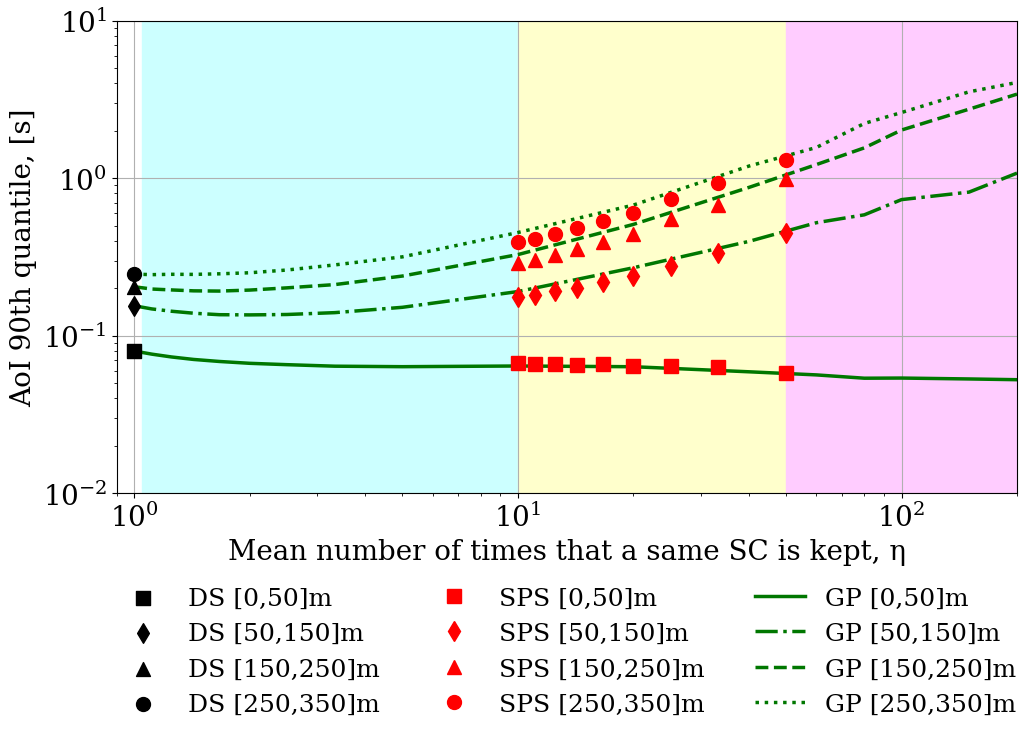

In [10]:
############## SPS, DS, GSPS AoI anomalies comparison (90th quantile)

import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data from the generated file
df_anomaly = pd.read_csv('pp/aoi_anomaly_dist_dens.csv')

# Convert columns to numeric, forcing errors to NaN
df_anomaly['pkeep'] = pd.to_numeric(df_anomaly['pkeep'], errors='coerce')
df_anomaly['aoi_90th_quantile'] = pd.to_numeric(df_anomaly['aoi_90th_quantile'], errors='coerce')
df_anomaly['eta'] = pd.to_numeric(df_anomaly['eta'], errors='coerce')

# Drop rows with NaN in critical columns
df_anomaly = df_anomaly.dropna(subset=['pkeep', 'aoi_90th_quantile', 'eta'])

# Ensure integer columns are correct
df_anomaly['RC_avg'] = df_anomaly['RC_avg'].astype(int)
df_anomaly['distance'] = df_anomaly['distance'].astype(int)

# Filter data for Geometric SPS (GSPS) and Standard SPS (SSPS)
df_GSPS = df_anomaly[df_anomaly['RC_avg'] == 1]
df_SSPS = df_anomaly[(df_anomaly['RC_avg'] == 10) & (df_anomaly['pkeep'] <= 0.8)]

# Define distances and styles
distances_max = [50, 150, 250, 350]
distances_min = [0, 50, 150, 250]
colors = ['#007700', 'red', '#007700', 'red']
linetypes = ['-', '', '-.', '', '--', '', ':', '']
markers = ['', 's', '', 'd', '', '^', '', 'o']
markers_scatter = ['s', '', 'd', '', '^', '', 'o', '']

def plot_metrics_combined(dfs, labels, labels_dist, colors, linetypes, markers, markers_scatter , metric, title, ylabel_suffix, ylims, save_path=None):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = '18'
    
    fig, ax = plt.subplots(figsize=(11, 9))
    
    for df, label, label_dist, color, linetype, marker, marker_scatter in zip(dfs, labels, labels_dist, colors, linetypes, markers, markers_scatter ):
        ax.plot(df['eta'], df[metric], marker=marker, markersize=10, color=color, linestyle=linetype, label=label, linewidth=2.5)
        
        # Add scatter point for eta == 1
        scatter_point = df[df['eta'] == 1]
        if not scatter_point.empty:
            ax.scatter(
                scatter_point['eta'].values[0], 
                scatter_point[metric].values[0], 
                color='black', 
                s=100, 
                zorder=5, 
                marker=marker_scatter, 
                label=label_dist
            )
    
    ax.set_xlim(0.9, 200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlabel('Mean number of times that a same SC is kept, η')
    ax.set_ylabel(title + ylabel_suffix)
    ax.grid()
    
    # Extract legend handles and labels
    handles, legend_labels = ax.get_legend_handles_labels()
    
    # Group legend by categories: DS, SPS, Geometric persistence
    grouped_legend = {"DS": [], "SPS": [], "GP": []}
    for handle, label in zip(handles, legend_labels):
        if "DS" in label:
            grouped_legend["DS"].append((handle, label))
        elif "SPS" in label:
            grouped_legend["SPS"].append((handle, label))
        elif "GP" in label:
            grouped_legend["GP"].append((handle, label))

    # Flatten the grouped handles and labels in column order
    sorted_handles = []
    sorted_labels = []
    for key in ["DS", "SPS", "GP"]:
        for handle, label in grouped_legend[key]:
            sorted_handles.append(handle)
            sorted_labels.append(label)
    
    # Create the legend with 3 columns
    ax.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    
    # Highlight regions
    plt.axvspan(1.05, 10, color='#CCFFFF', label='') 
    plt.axvspan(10, 50, color='#FFFFCC', label='') 
    plt.axvspan(50, 200, color='#FFCCFF', label='') 

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        fig.savefig(f"{save_path}/{metric}_combined_vs_eta_regions.eps", format='eps', bbox_inches='tight')
        print(f"Plot saved: {save_path}/{metric}_combined_vs_eta_regions.eps")
    else:
        plt.show()

# Collect all curves for each distance
dfs = []
labels = []
labels_dist =[]

for distance_min, distance_max in zip(distances_min, distances_max):
    # Filter data for the distance range
    df_GSPS_filtered = df_GSPS[(df_GSPS['distance'] > distance_min) & (df_GSPS['distance'] <= distance_max)]
    df_SSPS_filtered = df_SSPS[(df_SSPS['distance'] > distance_min) & (df_SSPS['distance'] <= distance_max)]
    
    # Add filtered datasets to dfs
    dfs.extend([df_GSPS_filtered, df_SSPS_filtered])
    
    # Add labels for the plots
    labels.append(f'GP [{distance_min},{distance_max}]m')
    labels.append(f'SPS [{distance_min},{distance_max}]m')
    
    # Add labels for scatter points
    labels_dist.extend([f'DS [{distance_min},{distance_max}]m', f'DS [{distance_min},{distance_max}]m'])


# Call the function to plot
plot_metrics_combined(
    dfs=dfs,
    labels=labels,
    labels_dist=labels_dist,
    colors=colors * 2,
    linetypes=linetypes,
    markers=markers,
    markers_scatter=markers_scatter,
    metric='aoi_90th_quantile',
    title='AoI 90th quantile',
    ylabel_suffix=', [s]',
    ylims=(0.01, 10),
    save_path='figures'
)




/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[
/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[
/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[


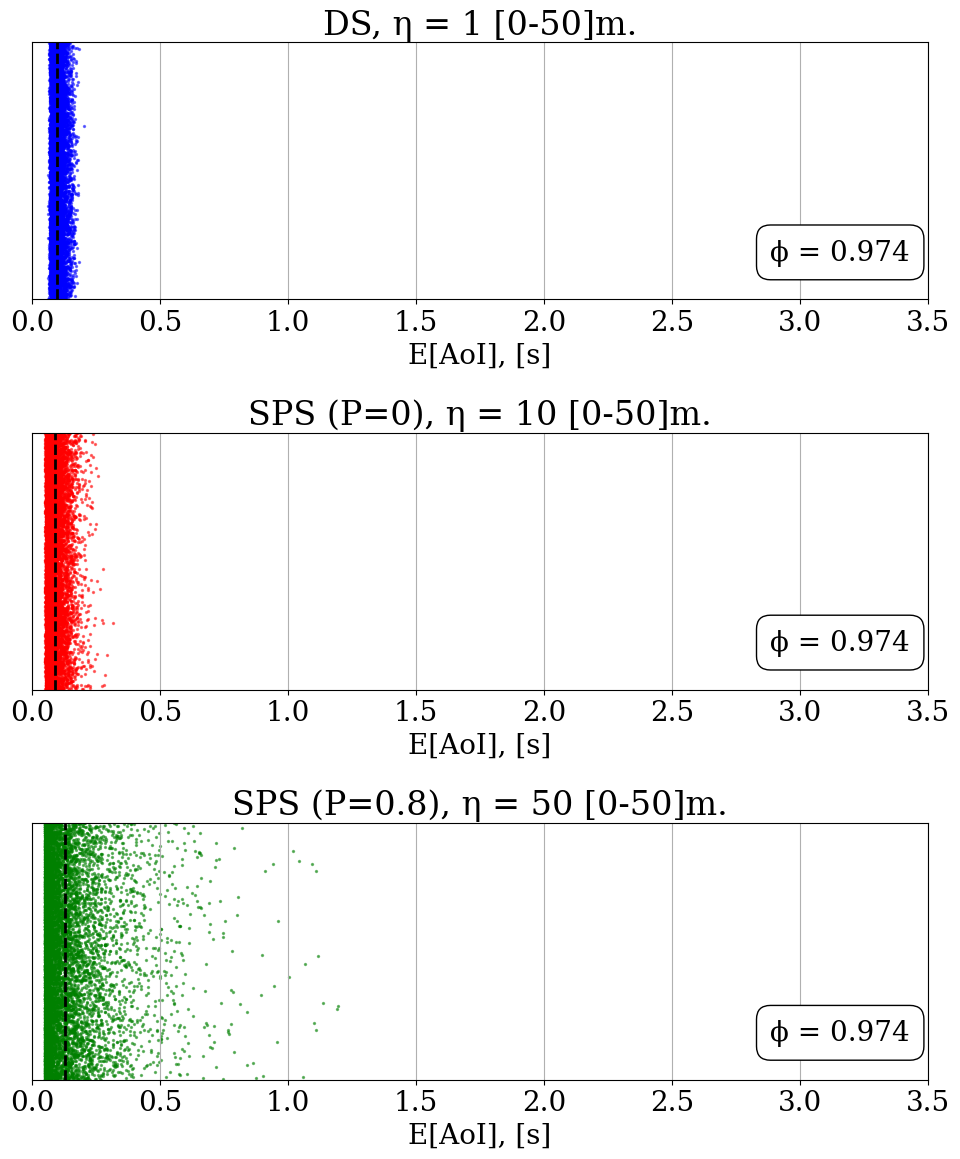

/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[
/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[
/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[


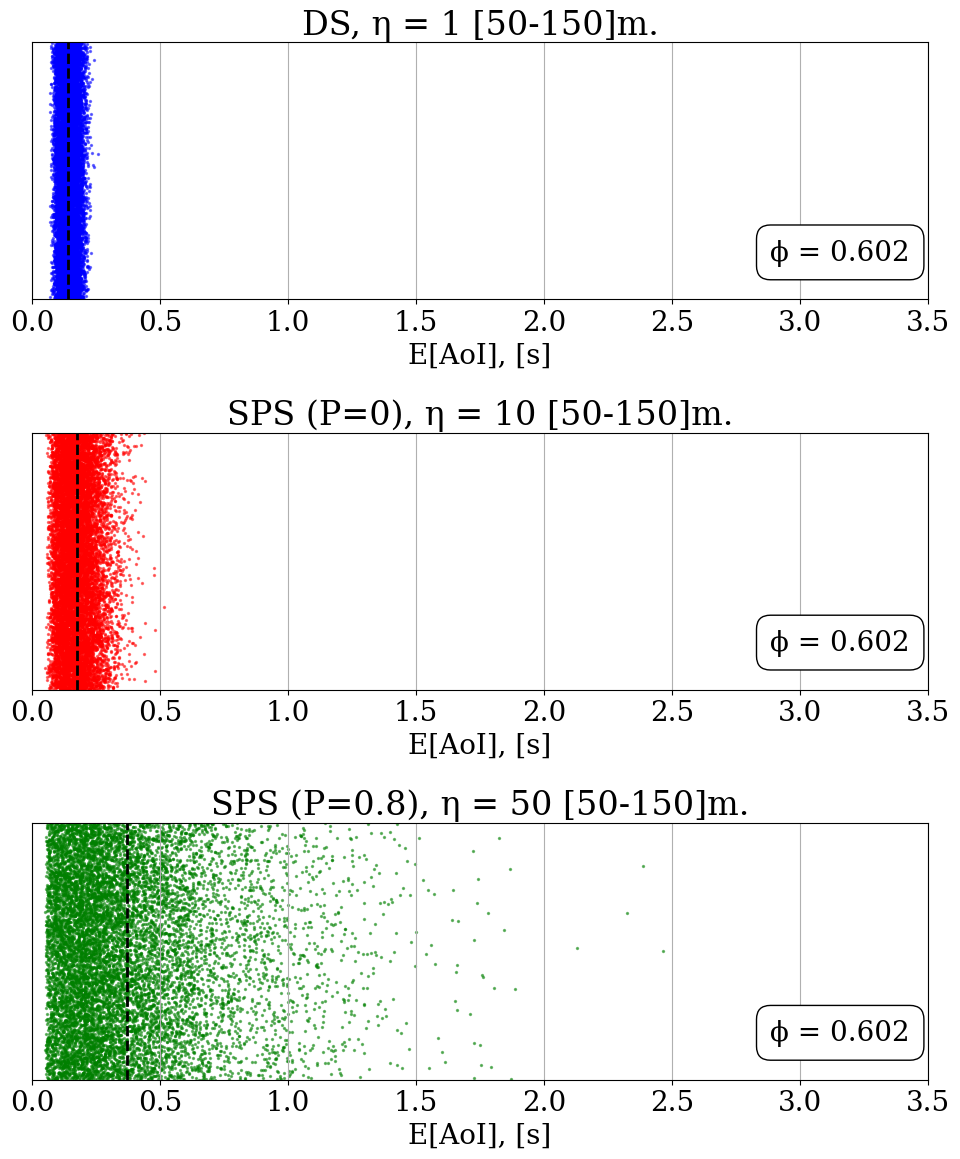

/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[
/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[
/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[


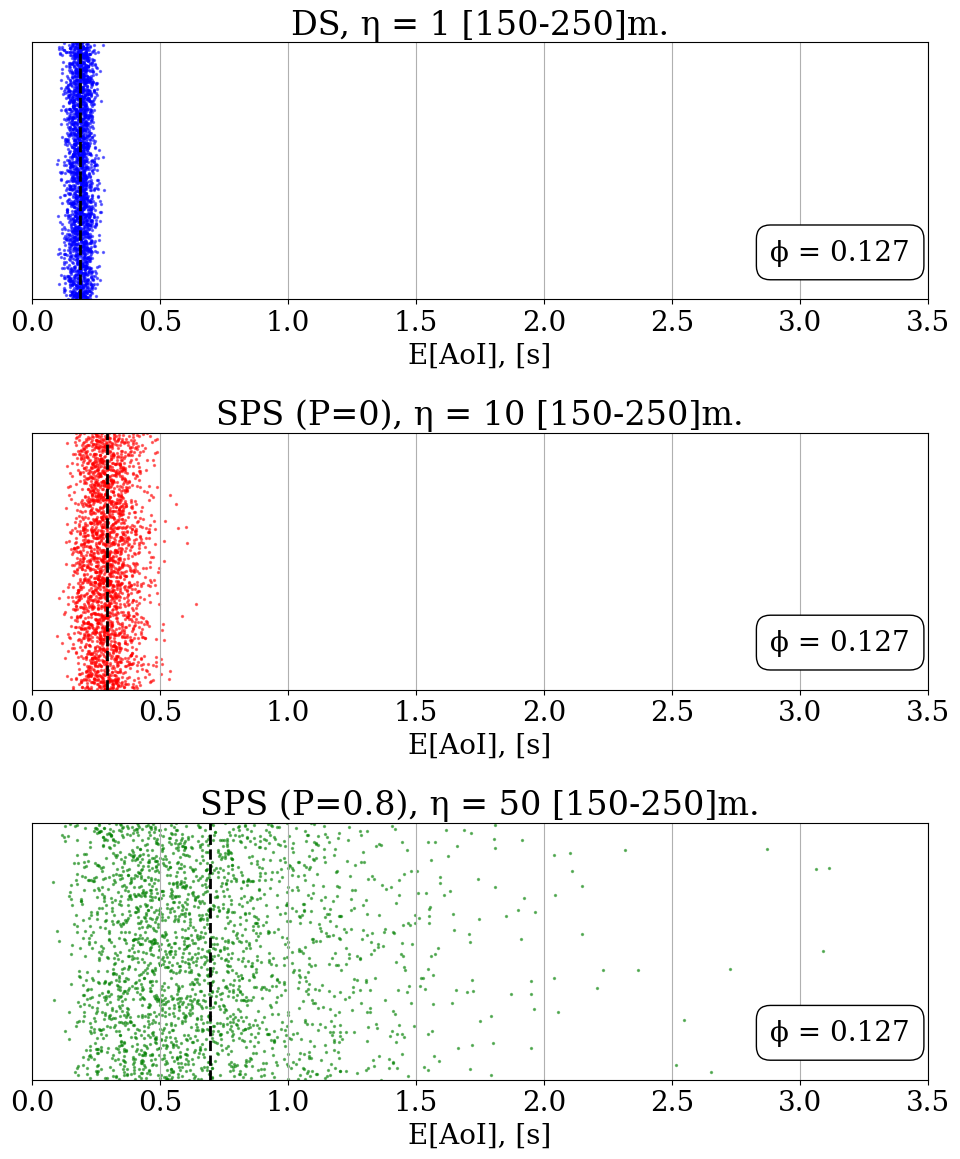

/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[
/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[
/tmp/ipykernel_2068819/2777586254.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data = raw.dropna(subset=['d'])[


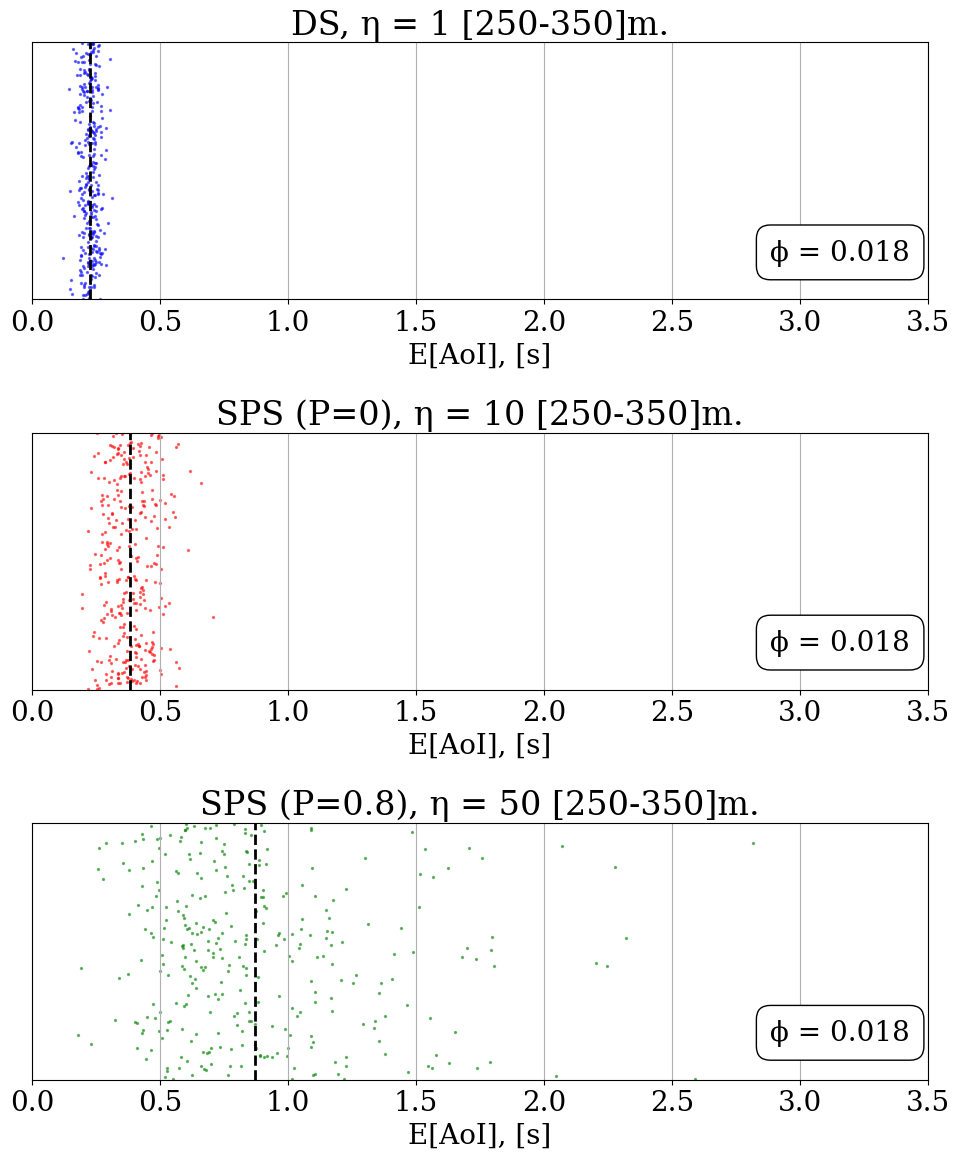

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Parameters
density = 700
distance_ranges = [(0, 50), (50, 150), (150, 250), (250, 350)]
pkeep_values = [0, 0.9, 0.8]
colors = ['blue', 'red', 'green']
titles = [
    "DS, η = 1",
    "SPS (P=0), η = 10",
    "SPS (P=0.8), η = 50"
]

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = '18'

# Load the data
file_path = f'pp/{density}_aoi_pairs_database_1.csv'
file_path515 = f'pp/{density}_aoi_pairs_database_515.csv'

columns = ['txid', 'rxid', 'paoi', 'aoi', 'pkeep', 'd']
data = pd.read_csv(file_path, names=columns)
data2 = pd.read_csv(file_path515, names=columns)

data3 = pd.read_csv(file_path, names=columns)
data4 = pd.read_csv(file_path515, names=columns)

# Convert columns to numeric and drop NaN
for df in [data, data2]:
    for col in ['paoi', 'aoi']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=['paoi', 'aoi','d'], inplace=True)

# Add random y-values for scatter plot
data['random_y'] = np.random.rand(len(data))
data2['random_y'] = np.random.rand(len(data2))

def calculate_phi_and_filtered_data(data, raw, pkeep, distance_min, distance_max):
    """Filter data and calculate φ."""
    filtered = data[
        (data['pkeep'] == pkeep) &
        (data['d'] > distance_min / 50) &
        (data['d'] <= distance_max / 50)
    ]
    all_data = raw.dropna(subset=['d'])[
        (raw['pkeep'] == pkeep) &
        (raw['d'] > distance_min / 50) &
        (raw['d'] <= distance_max / 50)
    ]
    phi = len(filtered) / len(all_data) if len(all_data) > 0 else 0
    return phi, filtered

def create_scatter_plot(ax, data, color, title, phi, distance_min, distance_max, n):
    """Create a scatter plot with a vertical line for the mean."""
    ax.scatter(data['aoi'], data['random_y'], alpha=0.5, color=color, s=2)
    ax.axvline(x=data['aoi'].mean(), color='black', linestyle='--', linewidth=2, label='')
    ax.set_title(f'{title} [{distance_min}-{distance_max}]m.')
    ax.set_xlabel('E[AoI], [s]')
    ax.set_xlim(0, 3.5)
    ax.set_ylim(0, 1)
    ax.yaxis.set_ticks([])
    ax.grid()
    ax.text(0.98, 0.13, f'ϕ = {phi:.3f}', ha='right', va='bottom', 
        transform=ax.transAxes, 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Generate plots for each distance range
for distance_min, distance_max in distance_ranges:
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharey=True)

    for i, (pkeep, color, title) in enumerate(zip(pkeep_values, colors, titles)):
        dataset = data if pkeep != 0.8 else data2  # Select dataset based on pkeep
        raw = data3 if pkeep != 0.8 else data4  # Select dataset based on pkeep
        phi, filtered = calculate_phi_and_filtered_data(dataset, raw, pkeep, distance_min, distance_max)
        create_scatter_plot(axes[i], filtered, color, title, phi, distance_min, distance_max, len(filtered))

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(f'figures/{density}_distribution_aoi_pairs_d{distance_min}_{distance_max}.png')
    plt.show()
